# Experiment: Parallel Sentence Mining or "Are these sentences the same?"

## Data

- I used NTREX data to train and FLORES data to test.
- For each language pair, take all parallel sentences as positive examples and sample an equal number of negative examples
    - Potential confounding variable: randomization of negative examples?

## Task
- Classify sentence pairs into `yes/no` based on whether the sentences are parallel or not

## Model and training
- Train a `bert-base-multilingual-cased` model for text classification 
- Trained for one epoch

## Evaluation
- Evaluation done using a confusion matrix, measured before and after training
- This can be converted to PRF1 as well as total correct / total incorrect

In [1]:
import pandas as pd
import numpy as np
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import seaborn as sns

Let's start by grabbing the results:

In [2]:
results_csv_path = "../experiments/same-sentence-all-vs-all-fixedseed/all_metrics_before_after_fixedseed.csv"

In [3]:
results = pd.read_csv(results_csv_path).set_index("language_pair")

We need a function to turn the raw counts into metrics:

In [4]:
def split_before_after(df):
    cols = df.columns
    before_replace_dict = {c: c.replace("_before", "") for c in cols}
    after_replace_dict = {c
                          : c.replace("_after", "") for c in cols}
    
    before = df[[c for c in cols if c.endswith("_before")]].rename(columns=before_replace_dict)
    after = df[[c for c in cols if c.endswith("_after")]].rename(columns=after_replace_dict)
    
    return before, after

In [5]:
def compute_prf1(df):
    out = pd.DataFrame(index=df.index)
    out['precision'] = df.true_positives / (df.true_positives + df.false_positives)
    out['recall'] = df.true_positives / (df.true_positives + df.false_negatives)
    out['f1'] = (2*out.precision*out.recall) / (out.precision + out.recall)
    
    return out

In [6]:
results_before, results_after = split_before_after(results)
prf1_before = compute_prf1(results_before)
prf1_after = compute_prf1(results_after)

In [7]:
prf1 = pd.merge(
    prf1_before, prf1_after, 
    suffixes=["_before", "_after"], 
    left_index=True, right_index=True
).reset_index().fillna(0)

In [8]:
prf1['f1_after'] = prf1.f1_after #- prf1.f1_before

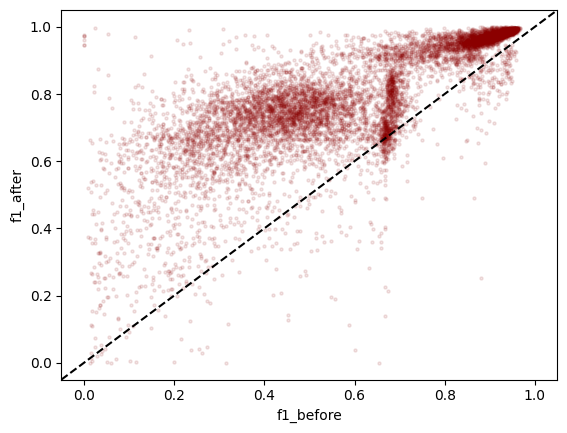

In [9]:
g = prf1.plot(kind="scatter", x="f1_before", y="f1_after", c='darkred', marker='.', alpha=.1)
g.axline([0,0], [1,1], c='k', ls='--')

Intersting. What about total correct?

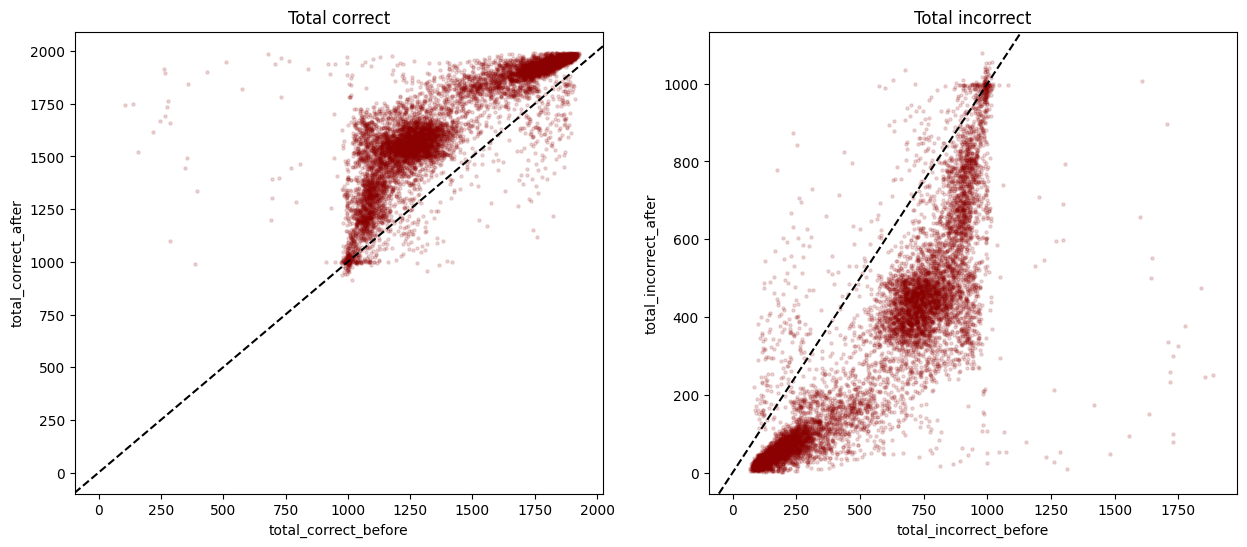

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

for ix, colname in enumerate(['correct', 'incorrect']):
    results.plot(
        kind="scatter", x=f"total_{colname}_before", y=f"total_{colname}_after", 
        c='darkred', marker='.', alpha=.15, ax=axes[ix]
    )
    axes[ix].axline([0,0], [1,1], c='k', ls='--')
    axes[ix].set_title(f'Total {colname}')

## Heatmaps

In [11]:
prf1['lang1'] = prf1.language_pair.str.split("-").apply(lambda l: l[0])
prf1['lang2'] = prf1.language_pair.str.split("-").apply(lambda l: l[1])

In [12]:
unique_langs = sorted(set(prf1.lang1) | set(prf1.lang2))

In [13]:
f1_after_mean = prf1.f1_after.mean()
f1_after_std = prf1.f1_after.std()

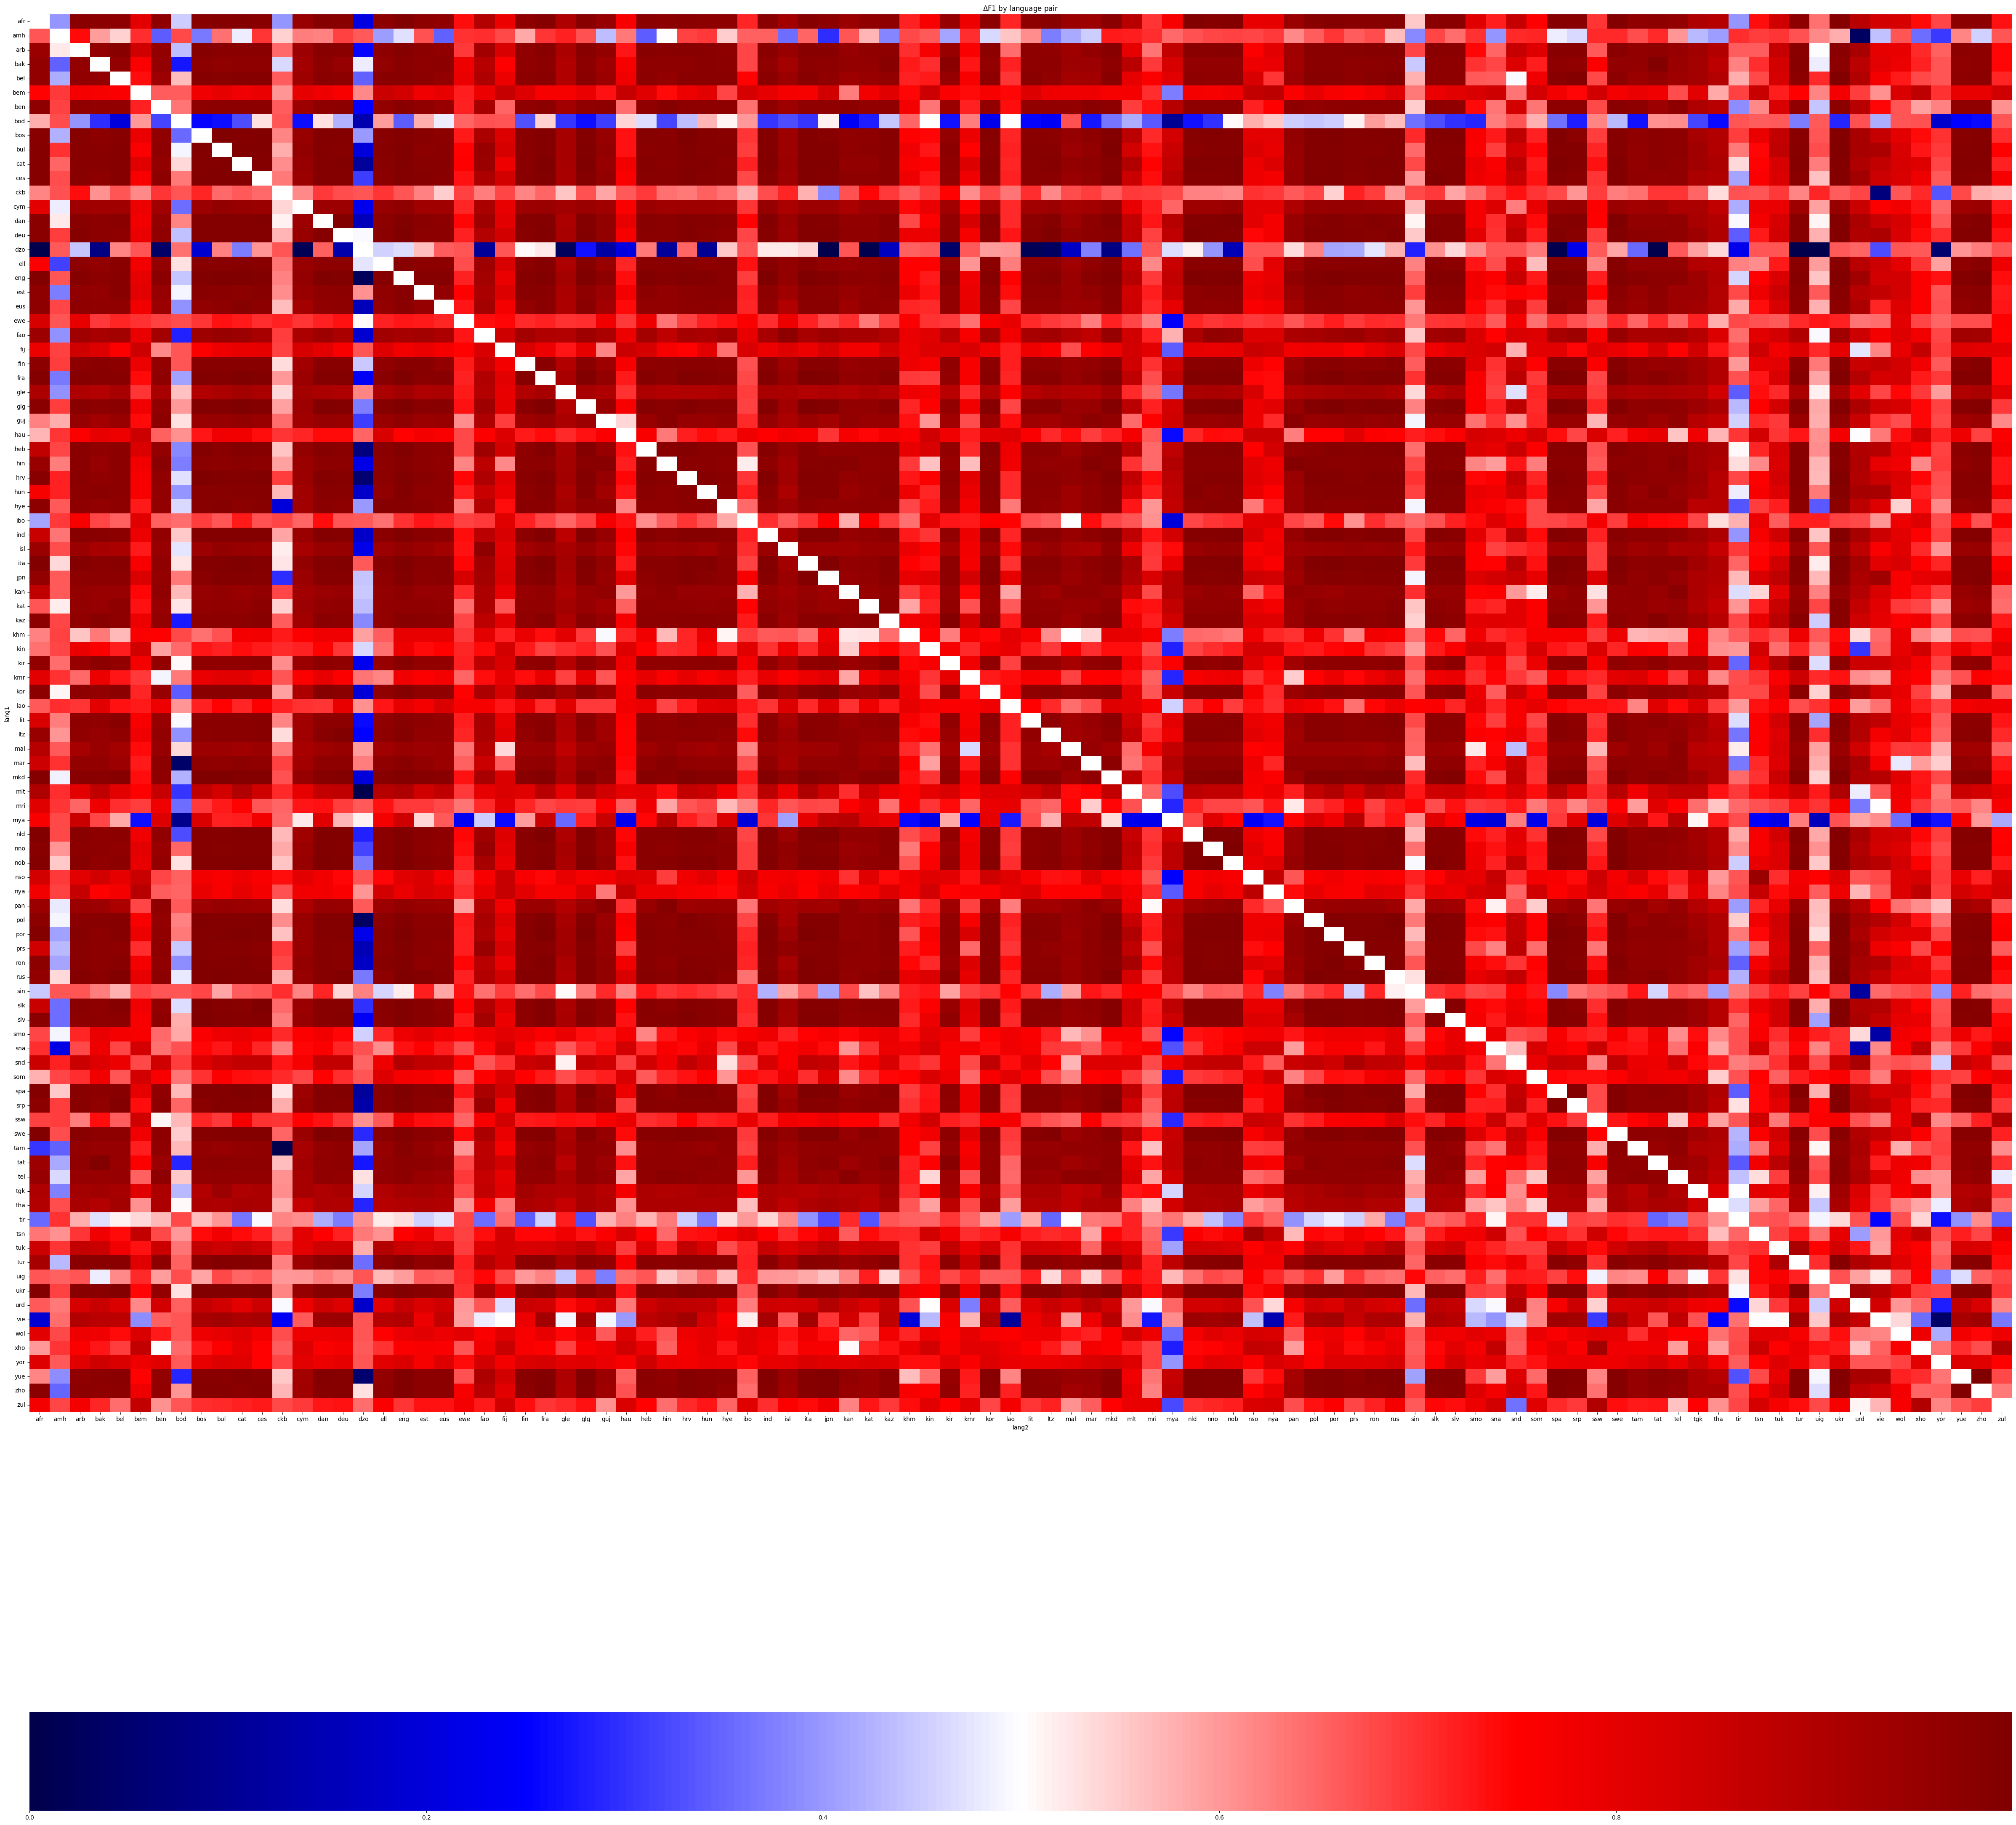

In [14]:
heat_fig, heat_ax = plt.subplots(nrows=1, ncols=1, figsize=(48, 48))
__df = prf1.set_index(['lang1', 'lang2'])\
            .f1_after\
            .unstack(level=-1)
sns.heatmap(__df, ax=heat_ax, cmap="seismic", cbar_kws={'orientation': 'horizontal'})
plt.title("$\Delta$F1 by language pair")
heat_fig.tight_layout()

# cbar = plt.gcf().axes[-1]
# cbar.set_position([cbar.get_position().x0, 0.1, cbar.get_position().width, 0.8])

## F1 vs. linguistic distances

In [15]:
import lang2vec.lang2vec as l2v
import itertools as it

In [16]:
def get_distance_matrix(langs, distance_type, make_human_readable=False):
    distance_matrix = l2v.distance(distance_type, langs)
    distance_matrix = pd.DataFrame(distance_matrix, index=langs, columns=langs)
    return distance_matrix

In [17]:
all_langs = set()
for pair in results.index.to_list():
    all_langs.update(pair.split("-"))
all_langs = sorted(all_langs)

In [18]:
distance_matrices = {
    distance_type: get_distance_matrix(list(all_langs), distance_type)
    for distance_type in l2v.DISTANCES
}

Let's plot $\Delta$F1 vs. linguistic distance

In [19]:
phon_dist_mat = distance_matrices['phonological']

In [20]:
def get_dist_vs_f1_df(distance_matrix, distance_type, f1_col='f1_after', within_col='within_how_many_sd', 
                      cluster_col='cluster_index'):
    phon_dist_series = distance_matrix.stack()
    phon_dist_series.rename_axis(index=['lang1', 'lang2'])
    subdf = prf1.set_index(['lang1', 'lang2'])[[f1_col, within_col, cluster_col]]
    f1_series = subdf[f1_col]
    within_series = subdf[within_col]
    cluster_series = subdf[cluster_col]
    
    _df = pd.DataFrame({'distance': phon_dist_series, f1_col: f1_series, 
                        within_col: within_series, cluster_col: cluster_series})
    _df['distance_type'] = distance_type
    
    return _df

In [21]:
def plot_dist_vs_delta_f1_all(make_human_readable=False, n_col=3, n_row=2,figsize=(24, 48), seaborn_mode=False, f1_col='f1_after'):
    row_col_indices = sorted(it.product(range(n_row), range(n_col)))

    heatmap_fig, heatmap_axes = plt.subplots(ncols=n_col, nrows=n_row, figsize=figsize)
    _distance_matrices = distance_matrices
    for (distance_type, matrix), (row_ix, col_ix) in zip(_distance_matrices.items(), row_col_indices):
        axis = heatmap_axes[row_ix][col_ix]
        _df = get_dist_vs_f1_df(matrix, distance_type, f1_col=f1_col)
        if seaborn_mode:
            sns.relplot(data=_df, x='distance', y=f1_col, hue='within_how_many_sd', ax=axis)
        else:
            _df.plot(kind='scatter', x='distance', y=f1_col, ax=axis, c='k', alpha=0.1, marker=',')
        avg = np.round(np.array(matrix).mean(axis=None), 2)
        axis.set_title(f"Distance: {distance_type} (avg: {avg})")
        
    #if make_human_readable:
    plt.tight_layout()

In [22]:
def standard_scale(series):
    mean = series.mean()
    std_dev = series.std()
    out = (series - mean)/std_dev
    out.index = series.index
    return out

def n_or_more(x, n=2):
    if x > n:
        return "more"
    else:
        return str(int(x))

prf1['f1_after_standardized'] = prf1.groupby('lang1', group_keys=True).f1_after.apply(standard_scale).droplevel(level=0)
prf1['within_how_many_sd'] = np.ceil(prf1.f1_after_standardized.abs()).apply(n_or_more)

In [23]:
f1_diff_stats_by_lang = prf1.groupby('lang1').f1_after.describe()[['mean', 'std']].to_dict(orient='index')

In [24]:
import sklearn.cluster as skc
def get_predicted_clusters(df, f1_col='f1_after', n_clusters=4):
    kmeans = skc.KMeans(n_clusters=n_clusters)
    kmeans_this = df[['lang1', 'lang2', f1_col]].set_index(['lang1', 'lang2']).unstack(level=1).fillna(0)
    langs = kmeans_this.index.to_list()
    predicted_clusters = kmeans.fit_predict(kmeans_this)
    return kmeans, dict(zip(langs, predicted_clusters))

In [25]:
kmeans_model, prf1_predicted_clusters = get_predicted_clusters(prf1, f1_col='f1_after', n_clusters=2)

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [26]:
prf1['cluster_index'] = prf1.lang1.apply(lambda l: prf1_predicted_clusters[l])

In [27]:
n_row=3
n_col=2
f1_col="f1_after"
row_col_indices = sorted(it.product(range(n_row), range(n_col)))
relplot_this = pd.concat(
    [
        get_dist_vs_f1_df(matrix, f1_col=f1_col, distance_type=distance_type) 
        for ((distance_type, matrix), (row_ix, col_ix))
        in zip(
            distance_matrices.items(), 
            row_col_indices
        )
    ])
relplot_this['within_how_many_sd'] = relplot_this['within_how_many_sd'].astype(str)

relplot_this.dropna(inplace=True)
relplot_this.reset_index(inplace=True)

In [28]:
import statsmodels as sm
import statsmodels.formula.api as smf

In [29]:
def get_regression_coefficient(df, distance_type, y_var_name="f1_after", x_var_name='distance'):
    relplot_fit = smf.ols(f'{y_var_name} ~ {x_var_name}', 
                          data=df[df.distance_type == distance_type]).fit()
    return relplot_fit.params.loc[x_var_name]

In [30]:
# sns.lmplot(data=relplot_this, col='cluster_index',row='distance_type', y='f1_after', x='distance')

In [31]:
def plot_lmplot_with_regression_line(df, distance_col='distance', f1_col='f1_after', subplot_by_cluster=False):
    regr_coefs = {
        dt: round(
            get_regression_coefficient(
                df, dt, 
                y_var_name=distance_col, 
                x_var_name=f1_col
            ), 3
        )  
        for dt in distance_matrices
    }
    
    _df = df.copy()
    _df['distance_type'] = [f"{dt} (beta = {regr_coefs[dt]})" for dt in df.distance_type]
    g = sns.lmplot(data=_df,
            x=distance_col, y=f1_col, 
               row='distance_type' if subplot_by_cluster else None, 
               col_wrap=3,
               col='cluster_index' if subplot_by_cluster else 'distance_type',
               markers='.',
               scatter_kws={"color": 'k', "alpha": 0.1},
               facet_kws={'sharex': False},
               line_kws={'color': 'red', 'linestyle': '--'}
                   
                  )

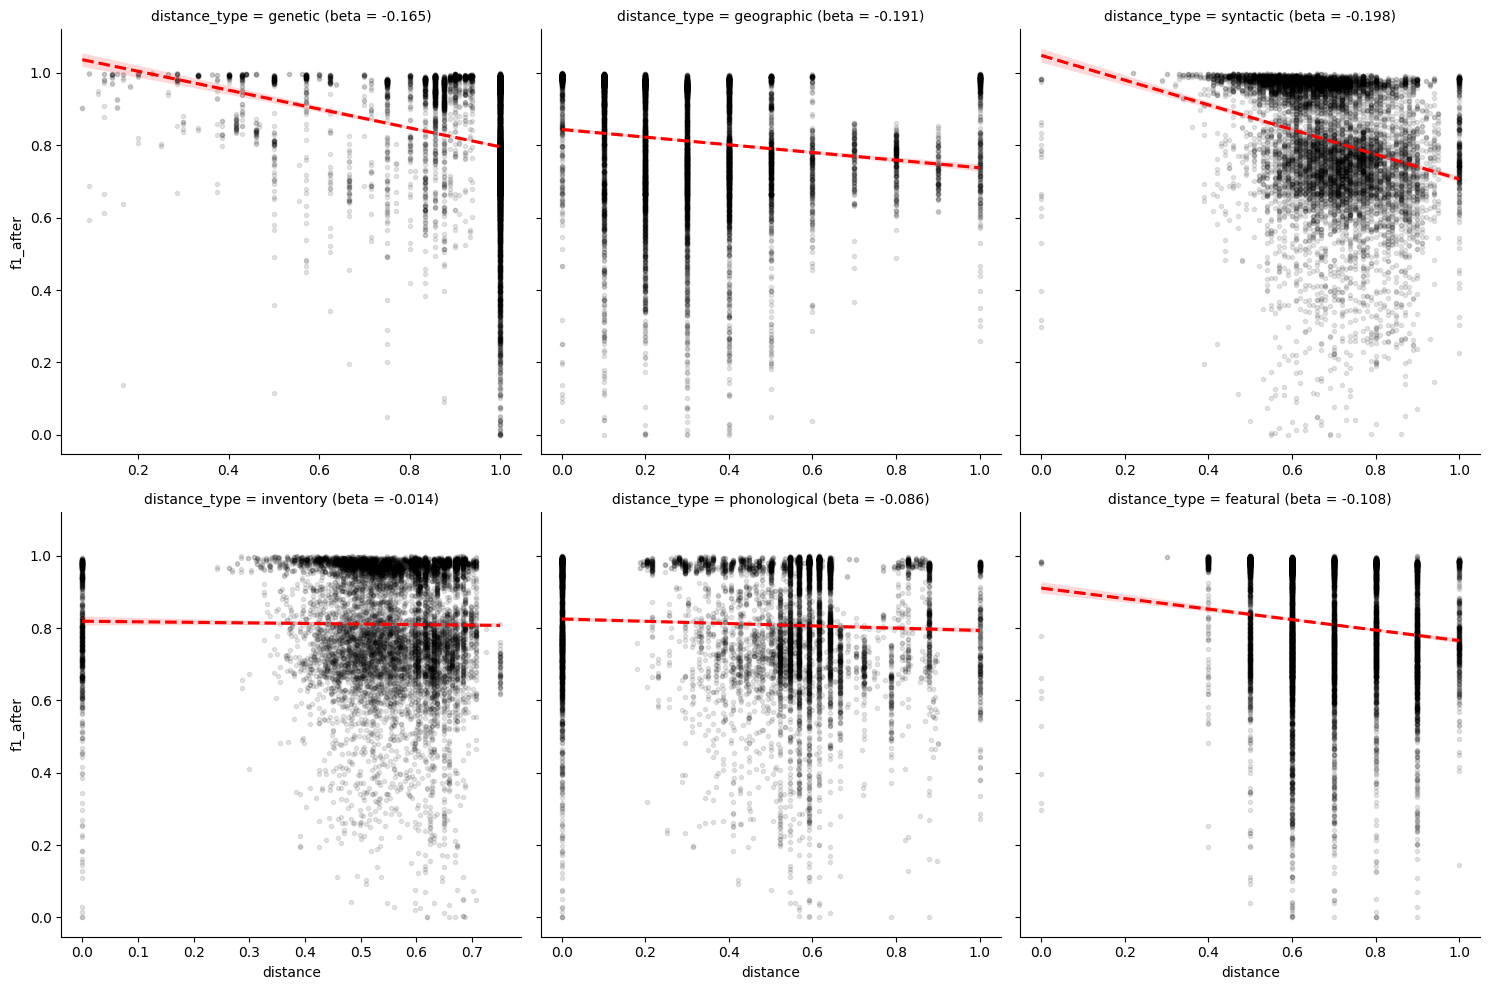

In [32]:
plot_lmplot_with_regression_line(relplot_this)

Z-score the distance

In [33]:
relplot_this_standardized = pd.concat(
    [
        get_dist_vs_f1_df(matrix, f1_col="f1_after_standardized", distance_type=distance_type) 
        for ((distance_type, matrix), (row_ix, col_ix))
        in zip(
            distance_matrices.items(), 
            row_col_indices
        )
    ])

relplot_this_standardized.dropna(inplace=True)
relplot_this_standardized.reset_index(inplace=True)

In [34]:
relplot_this_standardized['distance_standardized'] = relplot_this_standardized.groupby('distance_type', group_keys=True).distance.apply(standard_scale).droplevel(level=0)

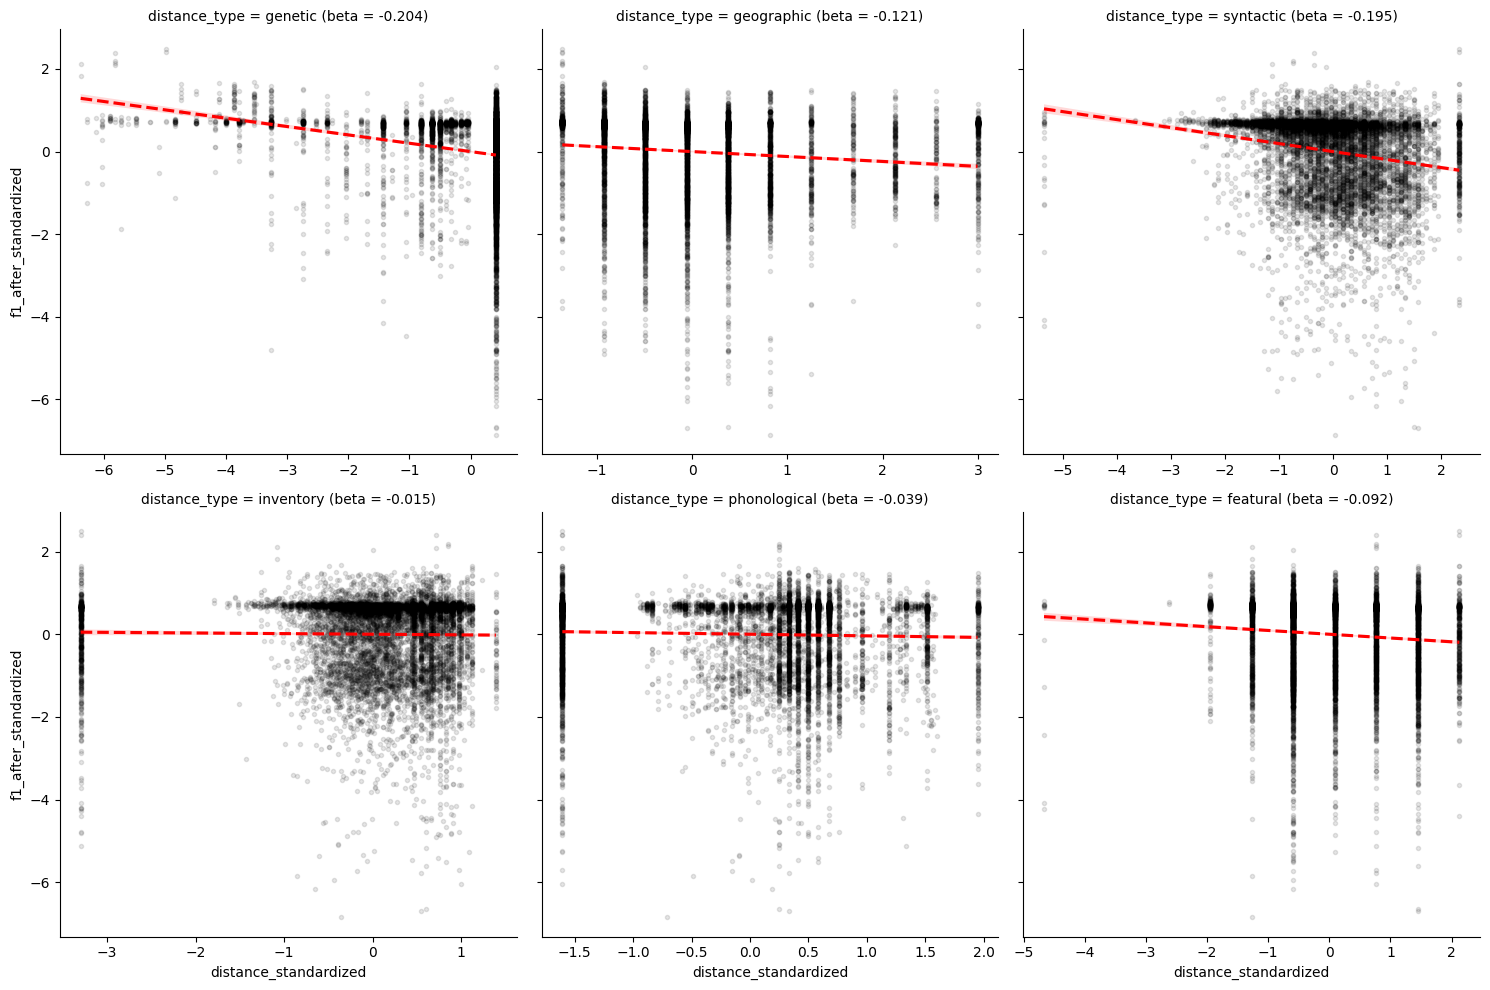

In [35]:
plot_lmplot_with_regression_line(relplot_this_standardized, 
                                 distance_col='distance_standardized', 
                                 f1_col='f1_after_standardized')

Doesn't seem like there's anything meaningful there either.

What about sorting the languages first by cluster ID, then alphabetically, and plotting the heatmap?

## Heatmap sorted by cluster ids

In [36]:
lang2cluster_id = prf1[['lang1', 'cluster_index']].sort_values(['cluster_index', 'lang1']).drop_duplicates().set_index('lang1').cluster_index.to_dict()

In [37]:
ordered_languages = prf1[['lang1', 'cluster_index']].sort_values(['cluster_index', 'lang1']).drop_duplicates().lang1.tolist()

In [38]:
from matplotlib.colors import TwoSlopeNorm

In [163]:
def plot_cluster_ordered_heatmap(lang2cluster_id, f1_col='f1_after', figsize=(48, 48), should_annotate=False, sort_col="cluster_index"):
    
    ordered_languages = prf1[['lang1', sort_col]]\
        .sort_values([sort_col, 'lang1'])\
        .drop_duplicates()\
        .lang1.tolist()
    
    __df = prf1.set_index(['lang1', 'lang2']).sort_values(sort_col)[f1_col].unstack(level=-1)
    __df = __df.loc[ordered_languages, ordered_languages]
    
    __df.index = [f"{lang} ({lang2cluster_id[lang]})" for lang in __df.index]
    __df.columns = [f"{lang} ({lang2cluster_id[lang]})" for lang in __df.columns]
    
    bounds = np.arange(1, 11)/10
    norm = BoundaryNorm(boundaries=bounds, ncolors=256)
    
    heat_fig, heat_ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    cmap="Oranges" # "seismic"
    sns.heatmap(__df, 
                ax=heat_ax, 
#                 cbar_kws={'orientation': 'horizontal'}, 
                norm=norm,
                annot=should_annotate, cmap=cmap)
    plt.title("$\Delta$F1 by language pair, sorted by cluster index")
    heat_fig.tight_layout()

In [164]:
prf1['within_how_many_sd'] = pd.Categorical(prf1['within_how_many_sd'], categories=["1", "2", "more"], ordered=True)

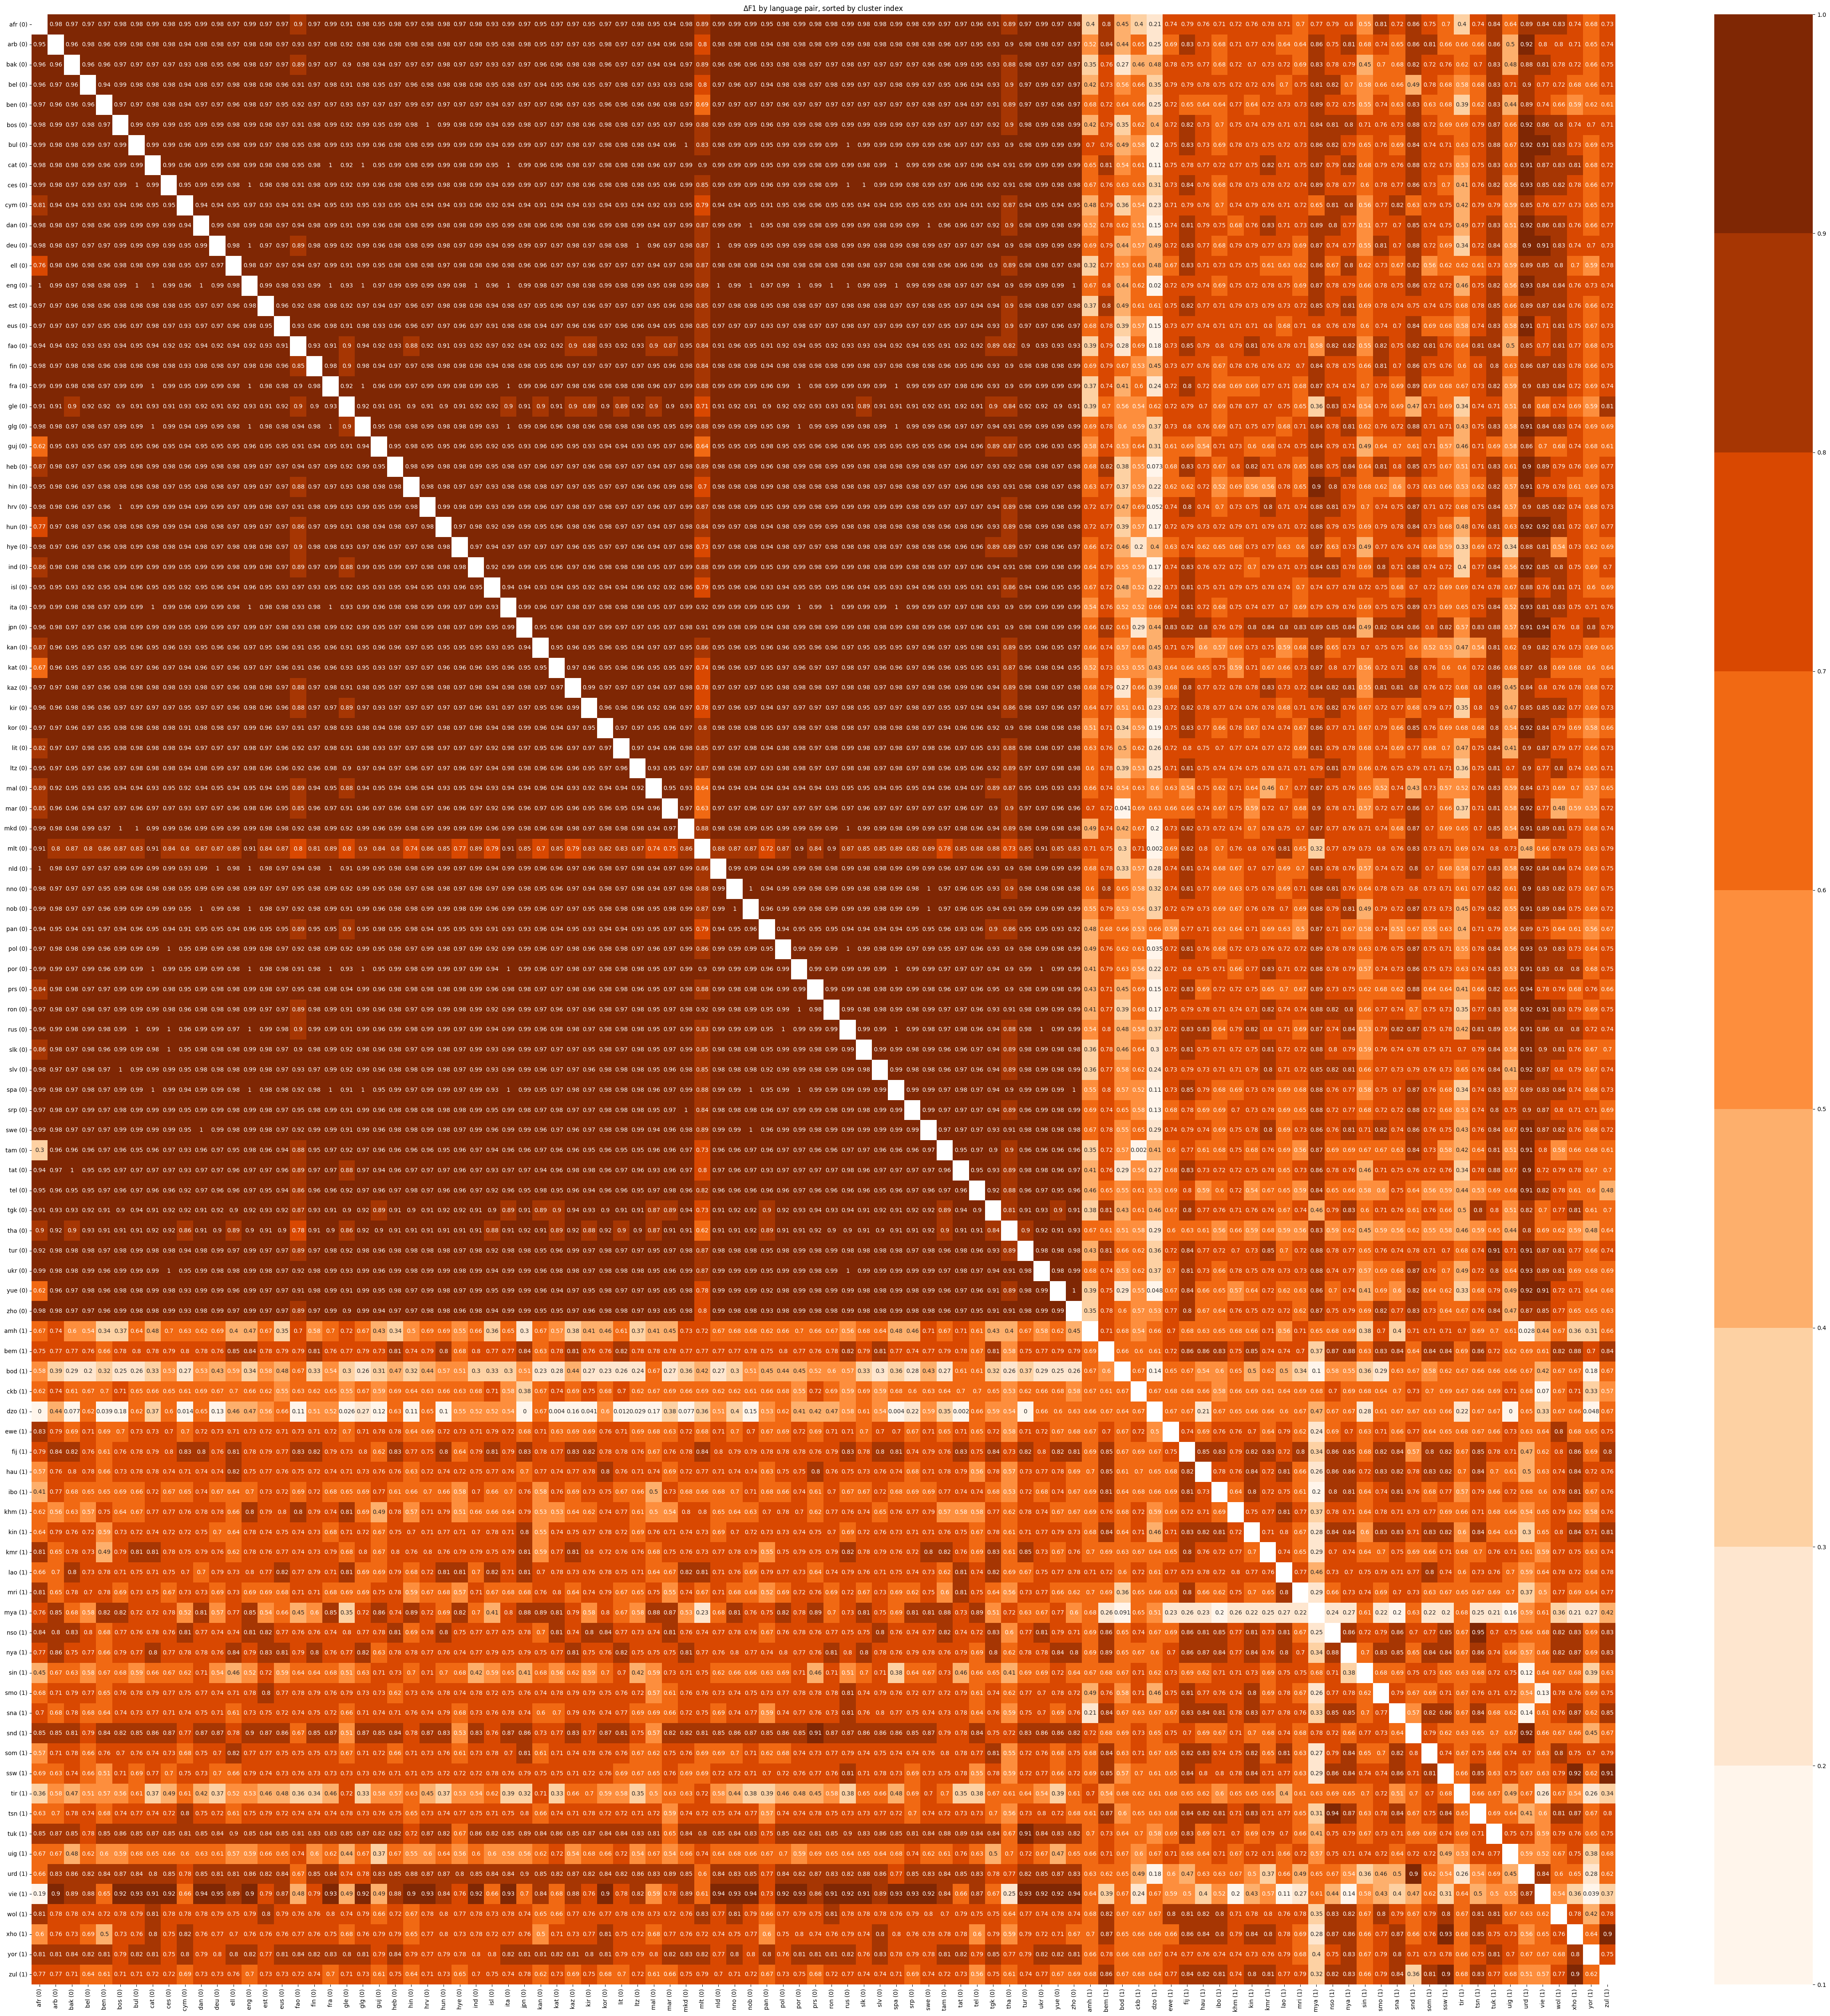

In [165]:
plot_cluster_ordered_heatmap(lang2cluster_id,f1_col='f1_after', should_annotate=True, sort_col="cluster_index")

Overall relationship between delta F1 and cluster index:

In [126]:
prf1['cluster_index'] = prf1.lang1.apply(lambda l2: lang2cluster_id[l2])
prf1['cluster_index2'] = prf1.lang2.apply(lambda l2: lang2cluster_id[l2])

In [127]:
cluster_vs_delta_f1 = smf.ols('f1_after ~ C(cluster_index):C(cluster_index2)', data=prf1).fit()

In [128]:
print(cluster_vs_delta_f1.summary())

                            OLS Regression Results                            
Dep. Variable:               f1_after   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     4643.
Date:                Fri, 28 Apr 2023   Prob (F-statistic):               0.00
Time:                        21:26:50   Log-Likelihood:                 7591.9
No. Observations:                9506   AIC:                        -1.518e+04
Df Residuals:                    9502   BIC:                        -1.515e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

## Inclusion in mBERT

In [67]:
import re

In [68]:
languages_path = "../data/ntrex/LANGUAGES_tab.tsv"

In [69]:
def invert_dict(d):
    return {v: k for k,v in d.items()}

In [70]:
lang_to_human_readable_language = pd.read_csv(
    languages_path, sep="\t", 
    header=None, names=["language_code", "language"]
).set_index('language_code').language.to_dict()

temporary = {}
for lang, long_lang in lang_to_human_readable_language.items():
    lang_no_orth = lang.split("-")[0]
    long_lang_no_orth = re.sub(pattern="\(.*\)", repl="", string=long_lang).strip()
    if lang_no_orth not in lang_to_human_readable_language:
        temporary[lang_no_orth] = long_lang_no_orth
        
lang_to_human_readable_language.update(temporary)

In [71]:
human_readable_language_to_lang = invert_dict(lang_to_human_readable_language)

In [72]:
prf1['lang1_human_readable'] = prf1.lang1.apply(lambda l: lang_to_human_readable_language[l])
prf1['lang2_human_readable'] = prf1.lang2.apply(lambda l: lang_to_human_readable_language[l])

In [73]:
mbert_langs = [
    "Afrikaans", "Albanian", "Arabic", 
    "Aragonese", "Armenian", "Asturian", 
    "Azerbaijani", "Bashkir", "Basque", 
    "Bavarian", "Belarusian", "Bengali", 
    "Bishnupriya Manipuri", "Bosnian", "Breton", 
    "Bulgarian", "Burmese","Myanmar", "Catalan", "Cebuano", 
    "Chechen", "Chinese (Simplified)", "Chinese (Traditional)", "Chinese",
    "Chuvash", "Croatian", "Czech", "Danish", "Dutch", "English", 
    "Estonian", "Finnish", "French", "Galician", "Georgian", "German", 
    "Greek", "Gujarati", "Haitian", "Hebrew", "Hindi", "Hungarian", 
    "Icelandic", "Ido", "Indonesian", "Irish", "Italian", "Japanese", 
    "Javanese", "Kannada", "Kazakh", "Kirghiz","Kyrgyz", "Korean", "Latin", 
    "Latvian", "Lithuanian", "Lombard", "Low Saxon", "Luxembourgish", 
    "Macedonian", "Malagasy", "Malay", "Malayalam", "Marathi", 
    "Minangkabau", "Nepali", "Newar", "Norwegian Bokmål", 
    "Norwegian Nynorsk", "Occitan", "Persian (Farsi)", "Farsi", "Persian",
    "Piedmontese", "Polish", "Portuguese", "Punjabi", "Panjabi","Romanian", 
    "Russian", "Scots", "Serbian", "Serbo-Croatian", "Sicilian", 
    "Slovak", "Slovenian", "South Azerbaijani", "Spanish", "Sundanese", 
    "Swahili", "Swedish", "Tagalog", "Tajik", "Tamil", "Tatar", 
    "Telugu", "Turkish", "Ukrainian", "Urdu", "Uzbek", 
    "Vietnamese", "Volapük", "Waray-Waray", 
    "Welsh", "West Frisian", "Western Punjabi", "Yoruba"
]

mbert_langs_set = set(mbert_langs)
not_in_mbert = set(prf1.lang1_human_readable.tolist() + prf1.lang2_human_readable.tolist()) - mbert_langs_set

In [74]:
prf1['lang1_in_mbert'] = prf1.lang1_human_readable.apply(lambda l: not (l in not_in_mbert)).astype(int)
prf1['lang2_in_mbert'] = prf1.lang2_human_readable.apply(lambda l: not (l in not_in_mbert)).astype(int)
prf1['both_in_mbert'] = ((prf1['lang1_in_mbert'] == 1) & (prf1['lang2_in_mbert'] == 1)).astype(int)
prf1['at_least_one_in_mbert'] = ((prf1['lang1_in_mbert'] == 1) | (prf1['lang2_in_mbert'] == 1)).astype(int)
prf1['neither_in_mbert'] = (~prf1.at_least_one_in_mbert.astype(bool)).astype(int)
prf1['exactly_one_in_mbert'] = (prf1.lang1_in_mbert.astype(bool) ^ prf1.lang2_in_mbert.astype(bool)).astype(int)

In [75]:
lang2mbert_cluster_id= prf1.set_index('lang1').lang1_in_mbert.to_dict()

In [106]:
# plot_cluster_ordered_heatmap(
#     lang2cluster_id=lang2mbert_cluster_id, 
#     f1_col='f1_after_standardized', should_annotate=True, 
#     sort_col="lang1_in_mbert"
# )

OK it seems like "is in mBERT pretraining langs" is a pretty big predictor! Let's take a look at only pairs where both languages were previously in mBERT:

In [130]:
from matplotlib.colors import SymLogNorm, BoundaryNorm

In [ ]:
SymLogNorm(linthresh=0.03, 
           linscale=0.03,
           vmin=-3.0, vmax=3.0, 
           base=np.exp(1))

In [159]:
def plot_cluster_ordered_heatmap_custom_matrix(prf1, lang2cluster_id,distance_mode=False, f1_col='f1_after', figsize=(48, 48), should_annotate=False, sort_col="cluster_index"):
    
    ordered_languages = prf1[['lang1', sort_col]]\
        .sort_values([sort_col, 'lang1'])\
        .drop_duplicates()\
        .lang1.tolist()
    
    __df = prf1.set_index(['lang1', 'lang2']).sort_values(sort_col)[f1_col].unstack(level=-1)
    __df = __df.loc[ordered_languages, ordered_languages]
    
    __df.index = [f"{lang} ({lang2cluster_id[lang]})" for lang in __df.index]
    __df.columns = [f"{lang} ({lang2cluster_id[lang]})" for lang in __df.columns]
    
#     vcenter = 0.5 if distance_mode else 0
#     vmin = min(prf1[f1_col])
#     vmax = max(prf1[f1_col])
    bounds = np.arange(1, 11)/10
    norm = BoundaryNorm(boundaries=bounds, ncolors=256)
    cmap= "Oranges" # "RdBu_r" # "seismic"
    
    heat_fig, heat_ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    sns.heatmap(__df, 
                ax=heat_ax, 
                norm=norm,
                annot=should_annotate, cmap=cmap)
    plt.title("$\Delta$F1 by language pair, sorted by cluster index")
    heat_fig.tight_layout()

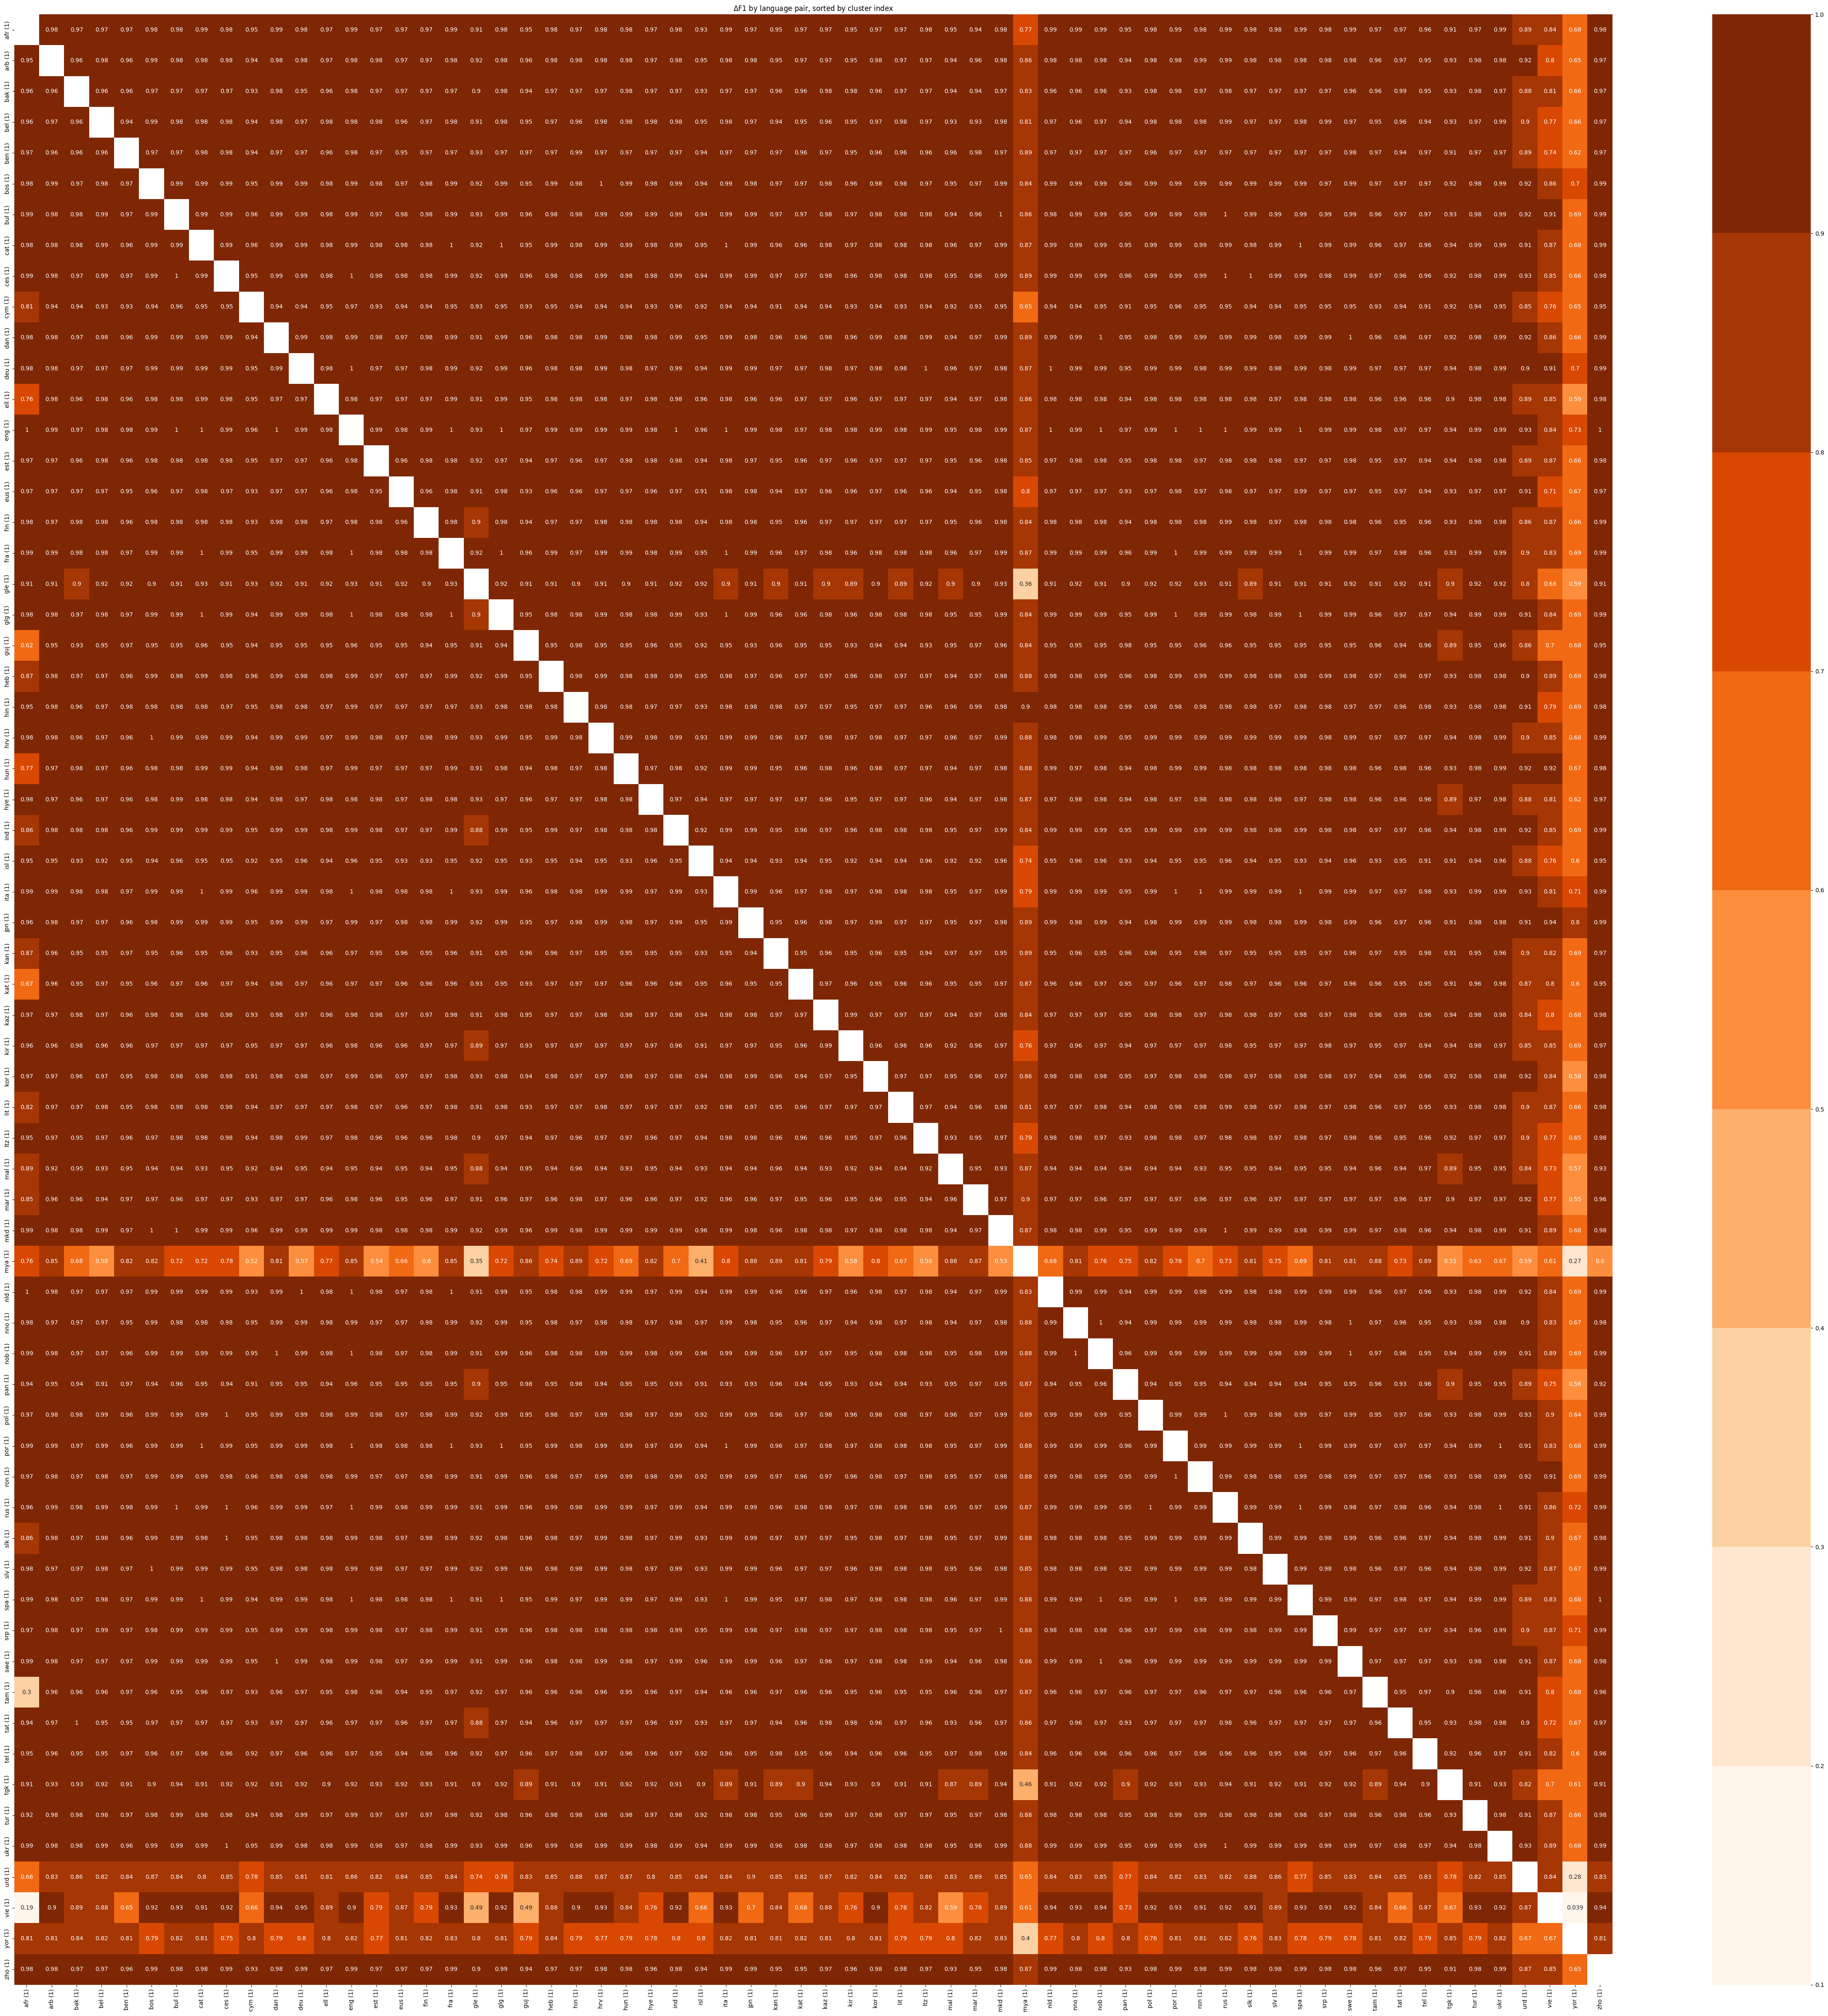

In [160]:
plot_cluster_ordered_heatmap_custom_matrix(prf1[prf1.both_in_mbert == 1], 
                                           lang2cluster_id=lang2mbert_cluster_id, 
                                           f1_col='f1_after', should_annotate=True, 
                                           sort_col="lang1_in_mbert")

and let's also plot the ones where neither was in mBERT:

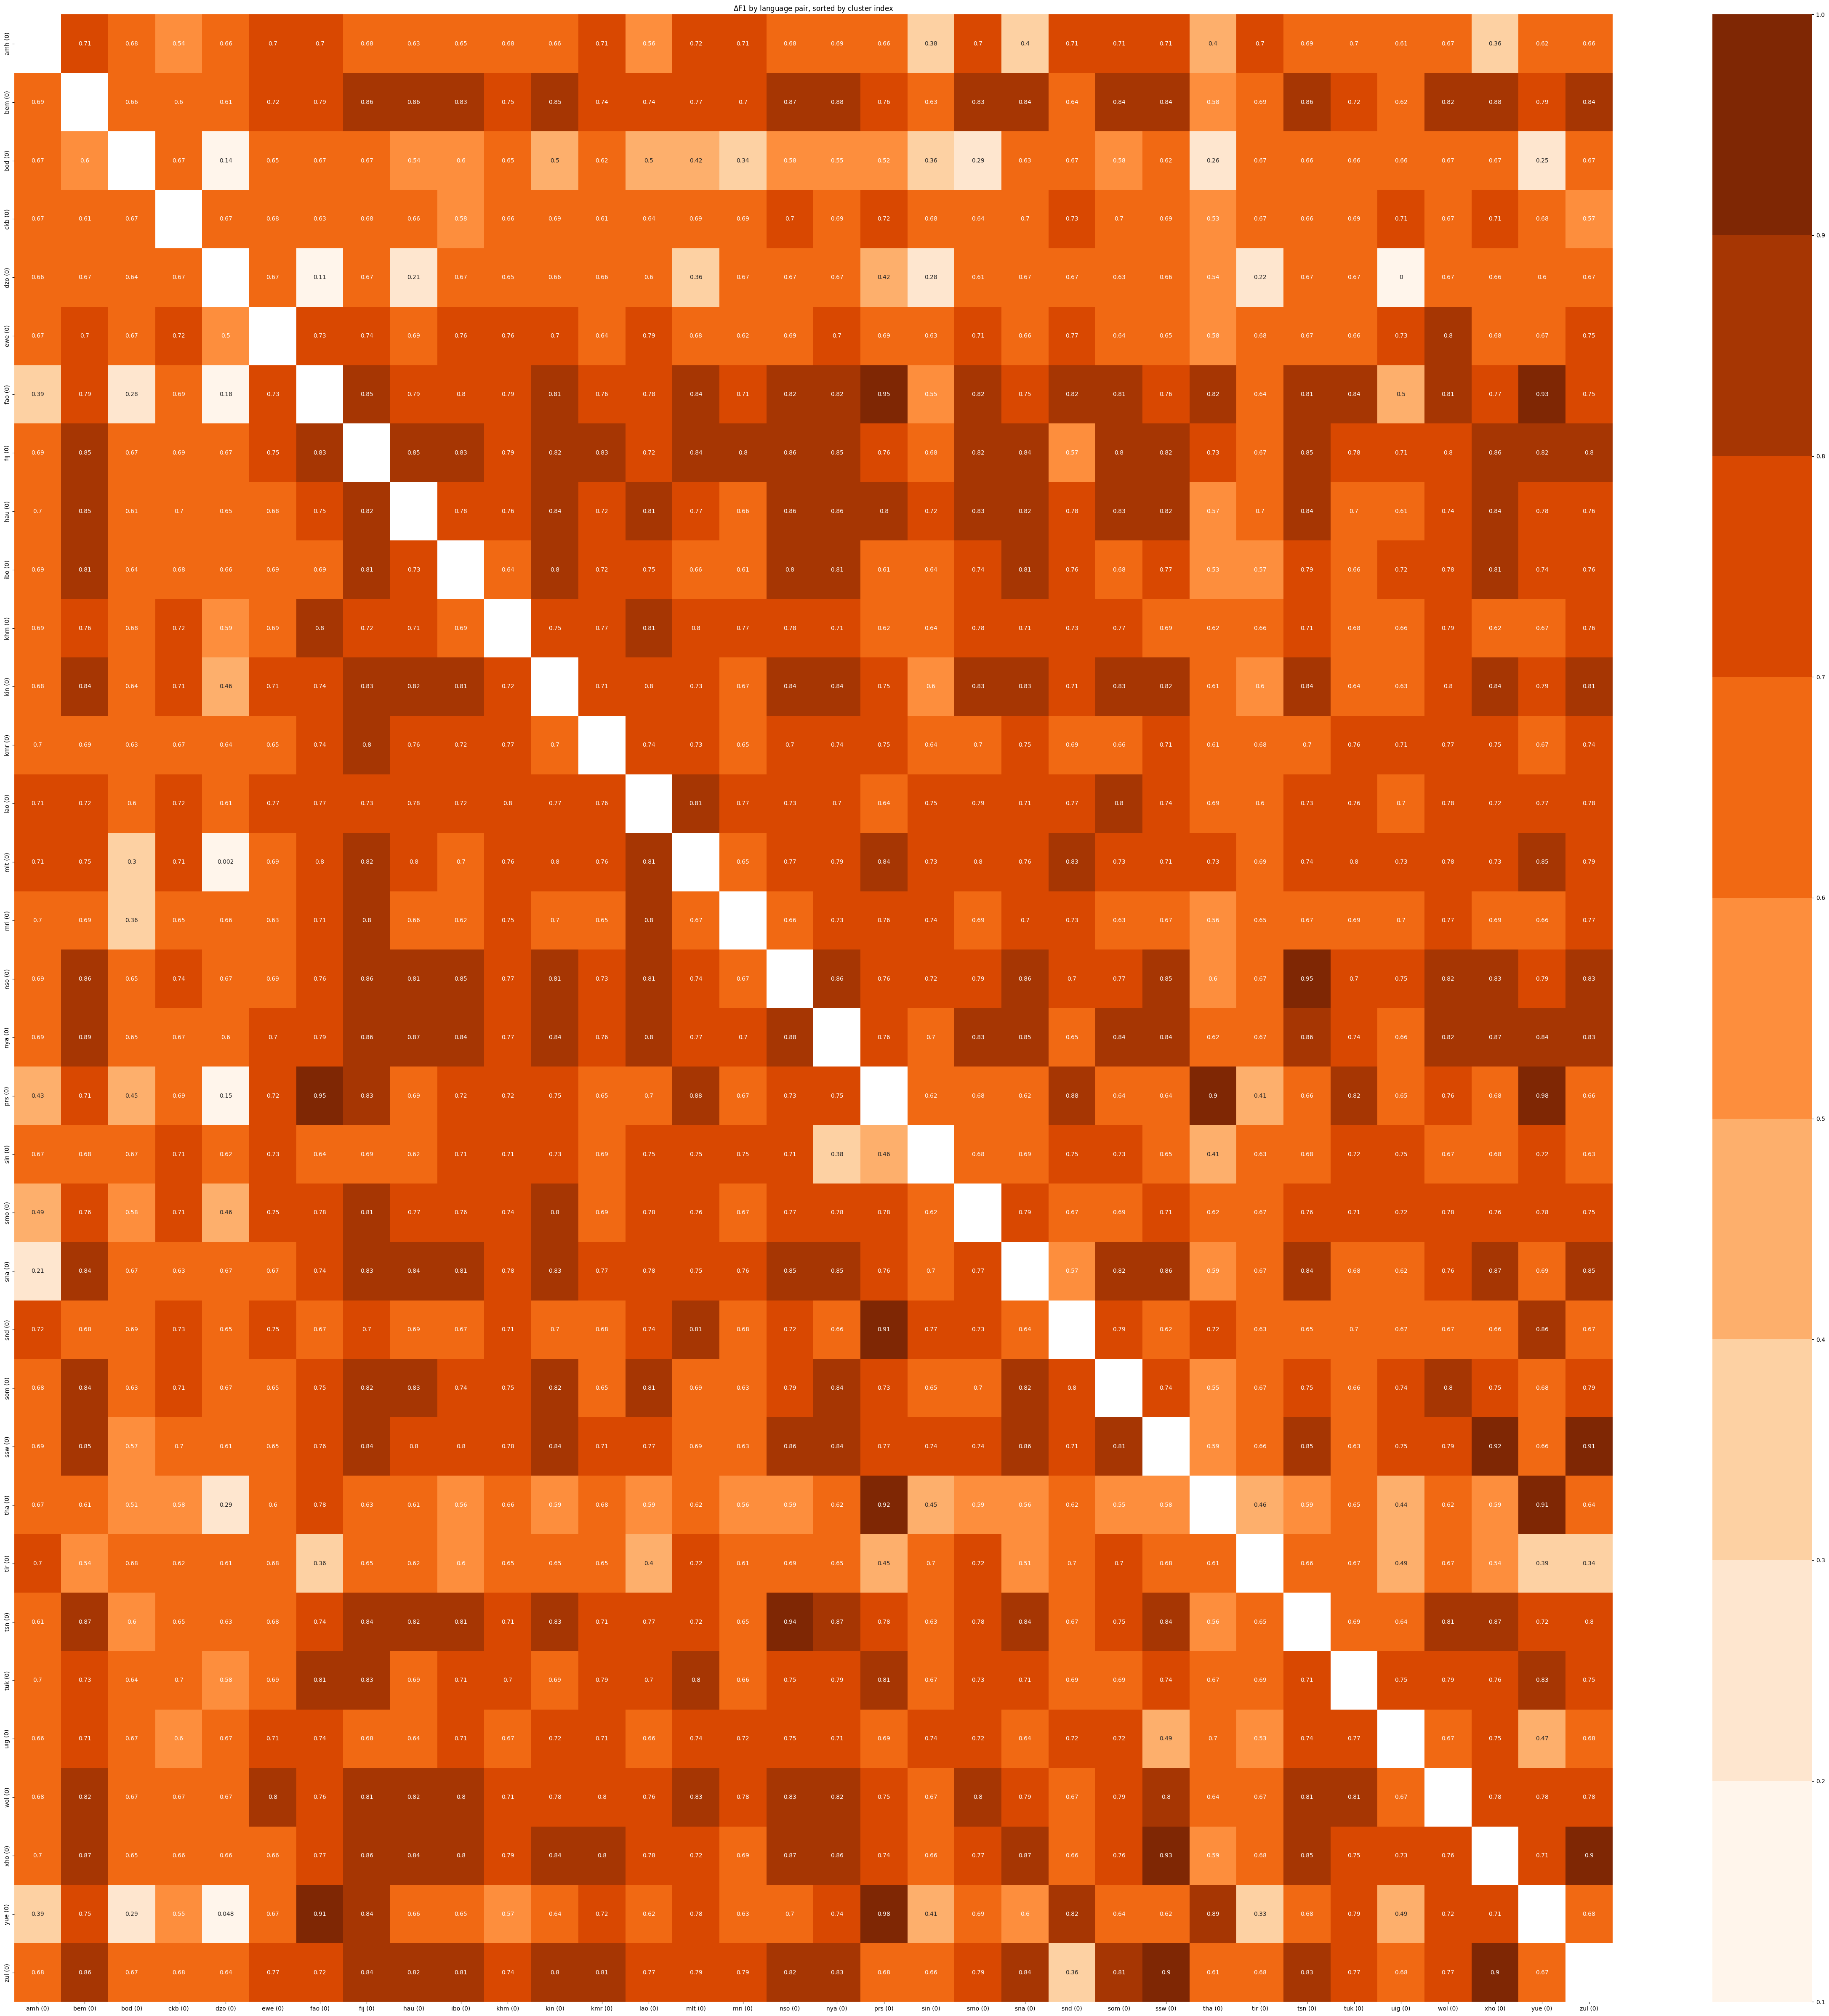

In [161]:
plot_cluster_ordered_heatmap_custom_matrix(prf1[prf1.neither_in_mbert == 1], 
                                           lang2cluster_id=lang2mbert_cluster_id, 
                                           f1_col='f1_after', should_annotate=True, 
                                           sort_col="lang1_in_mbert")

and where only one is in mBERT:

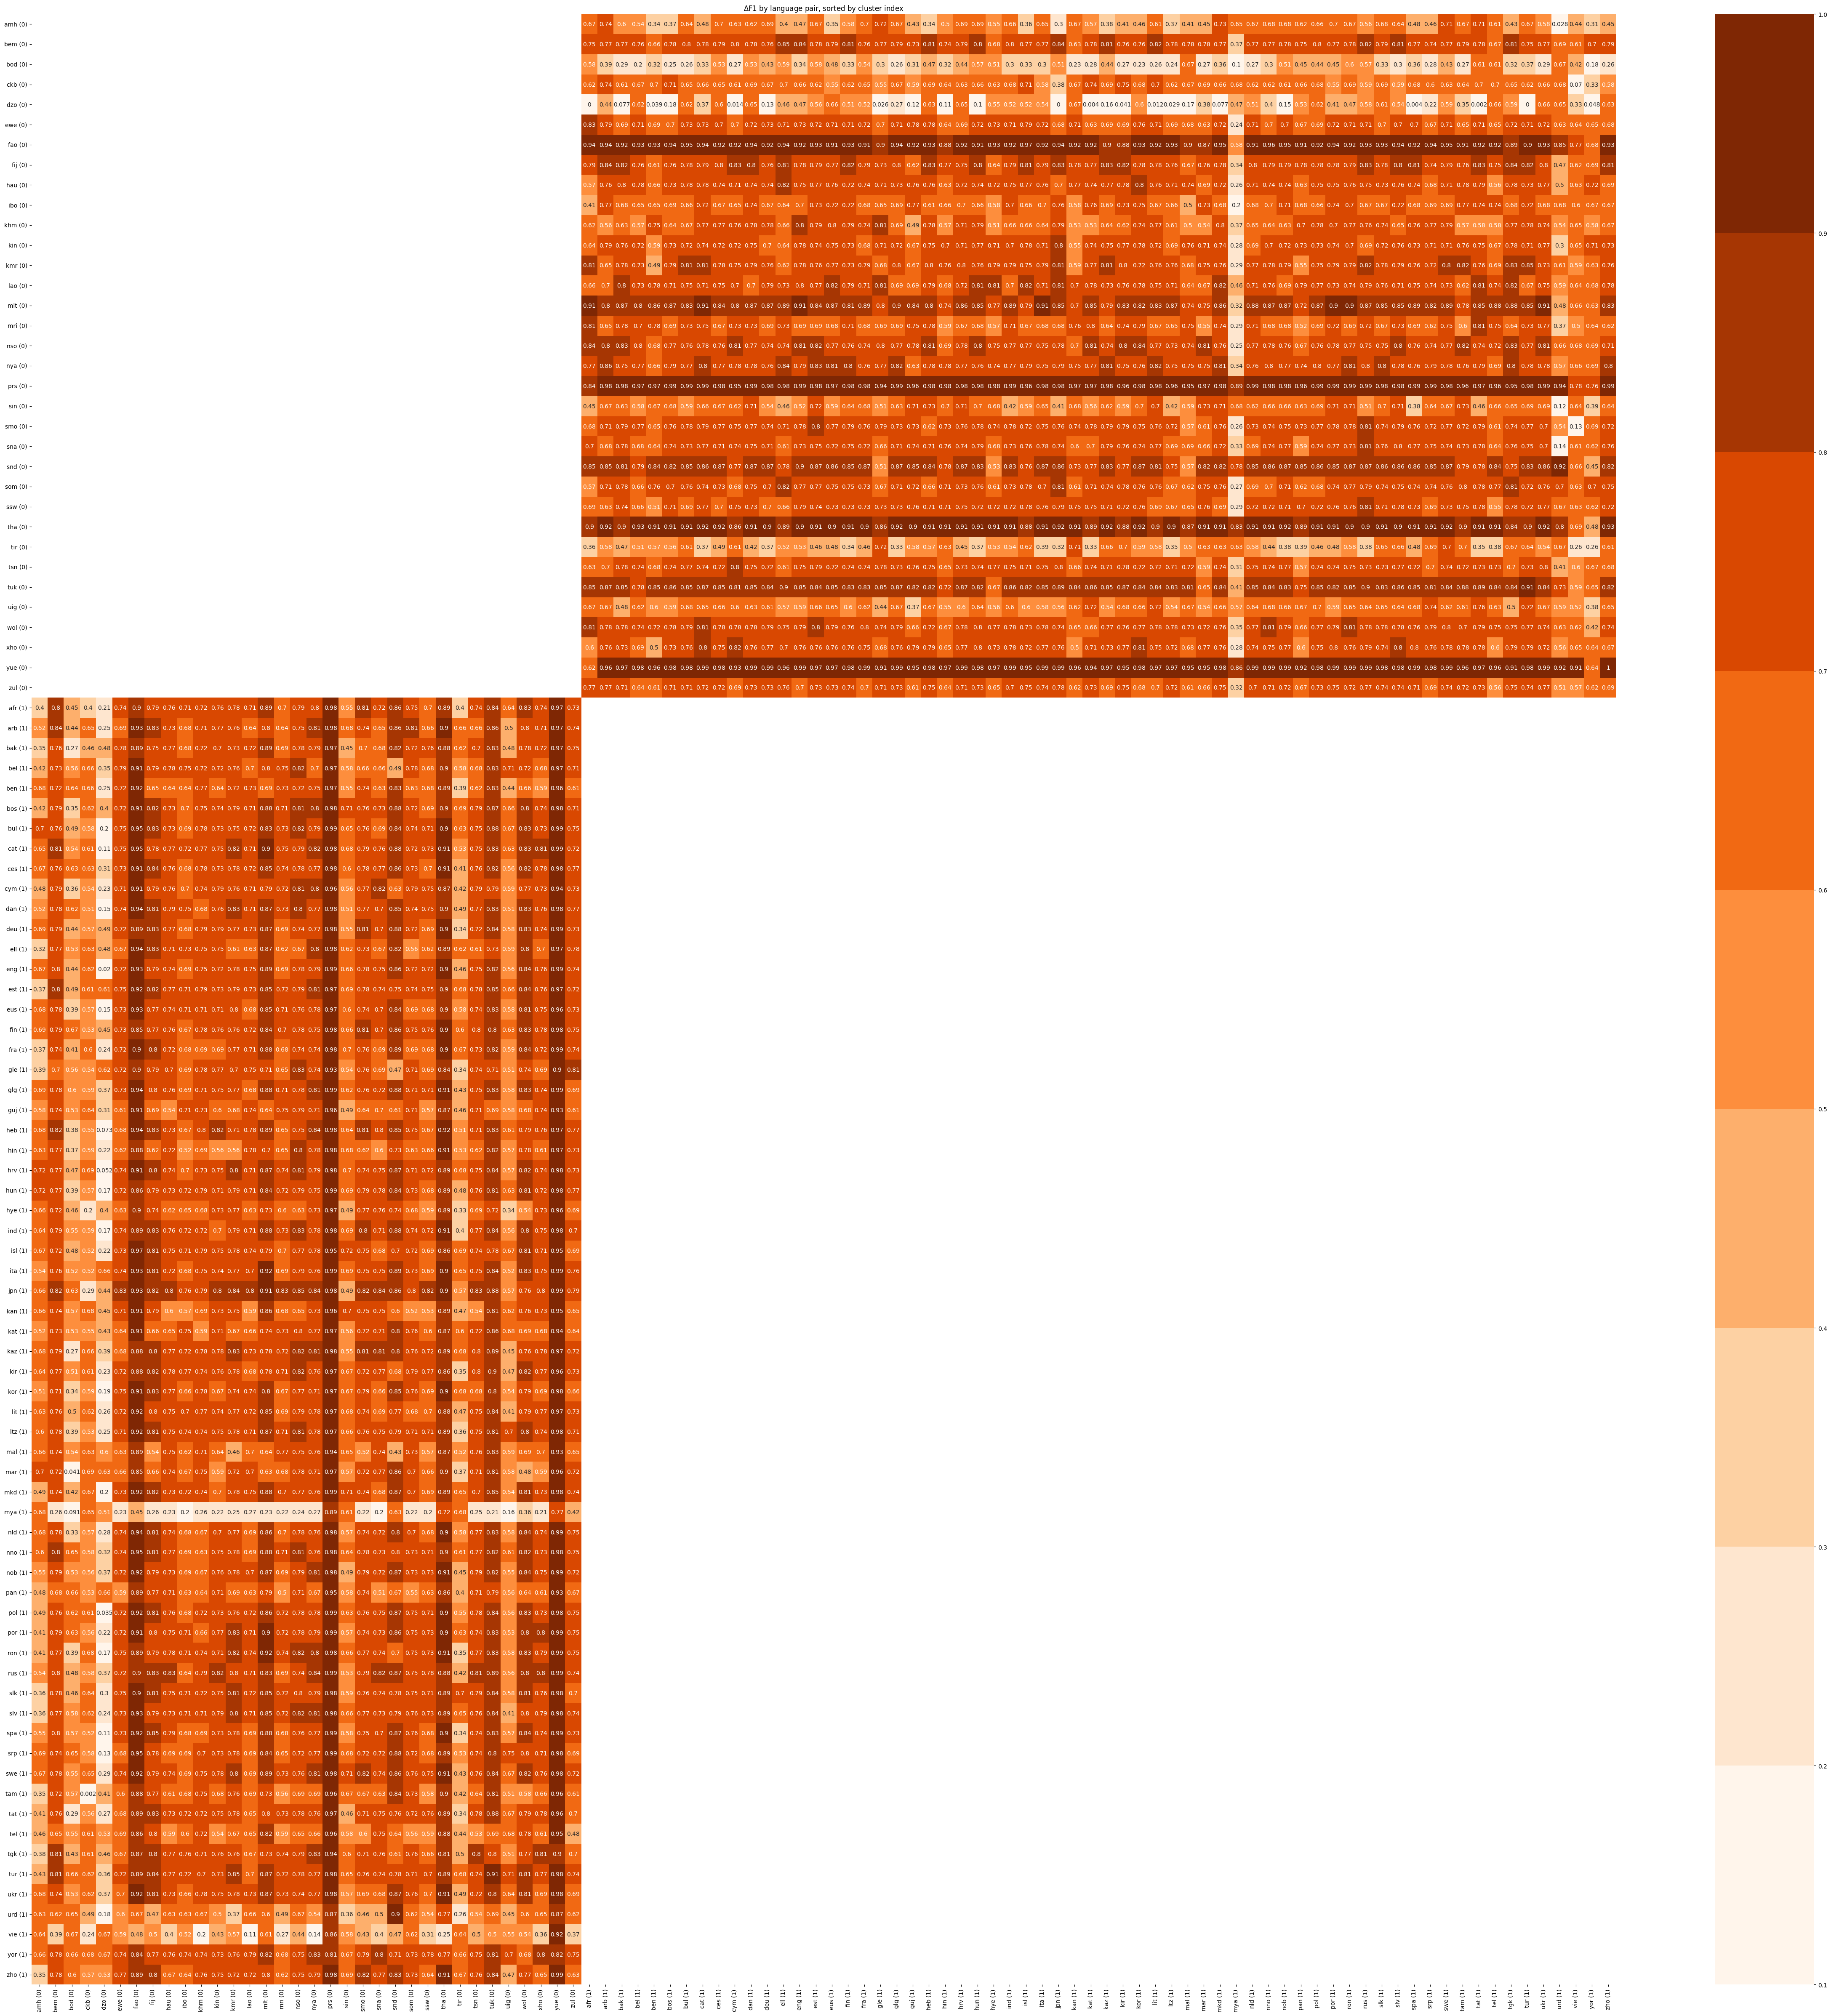

In [162]:
plot_cluster_ordered_heatmap_custom_matrix(prf1[prf1.exactly_one_in_mbert == 1], 
                                           lang2cluster_id=lang2mbert_cluster_id, 
                                           f1_col='f1_after', should_annotate=True, 
                                           sort_col="lang1_in_mbert")

## Best languages

In [168]:
pd.DataFrame.assign?

array([[<Axes: title={'center': 'f1_range'}, ylabel='lang1_human_readable'>,
        <Axes: title={'center': 'mean'}, ylabel='lang1_human_readable'>,
        <Axes: title={'center': 'scaled_mean_f1'}, ylabel='lang1_human_readable'>]],
      dtype=object)

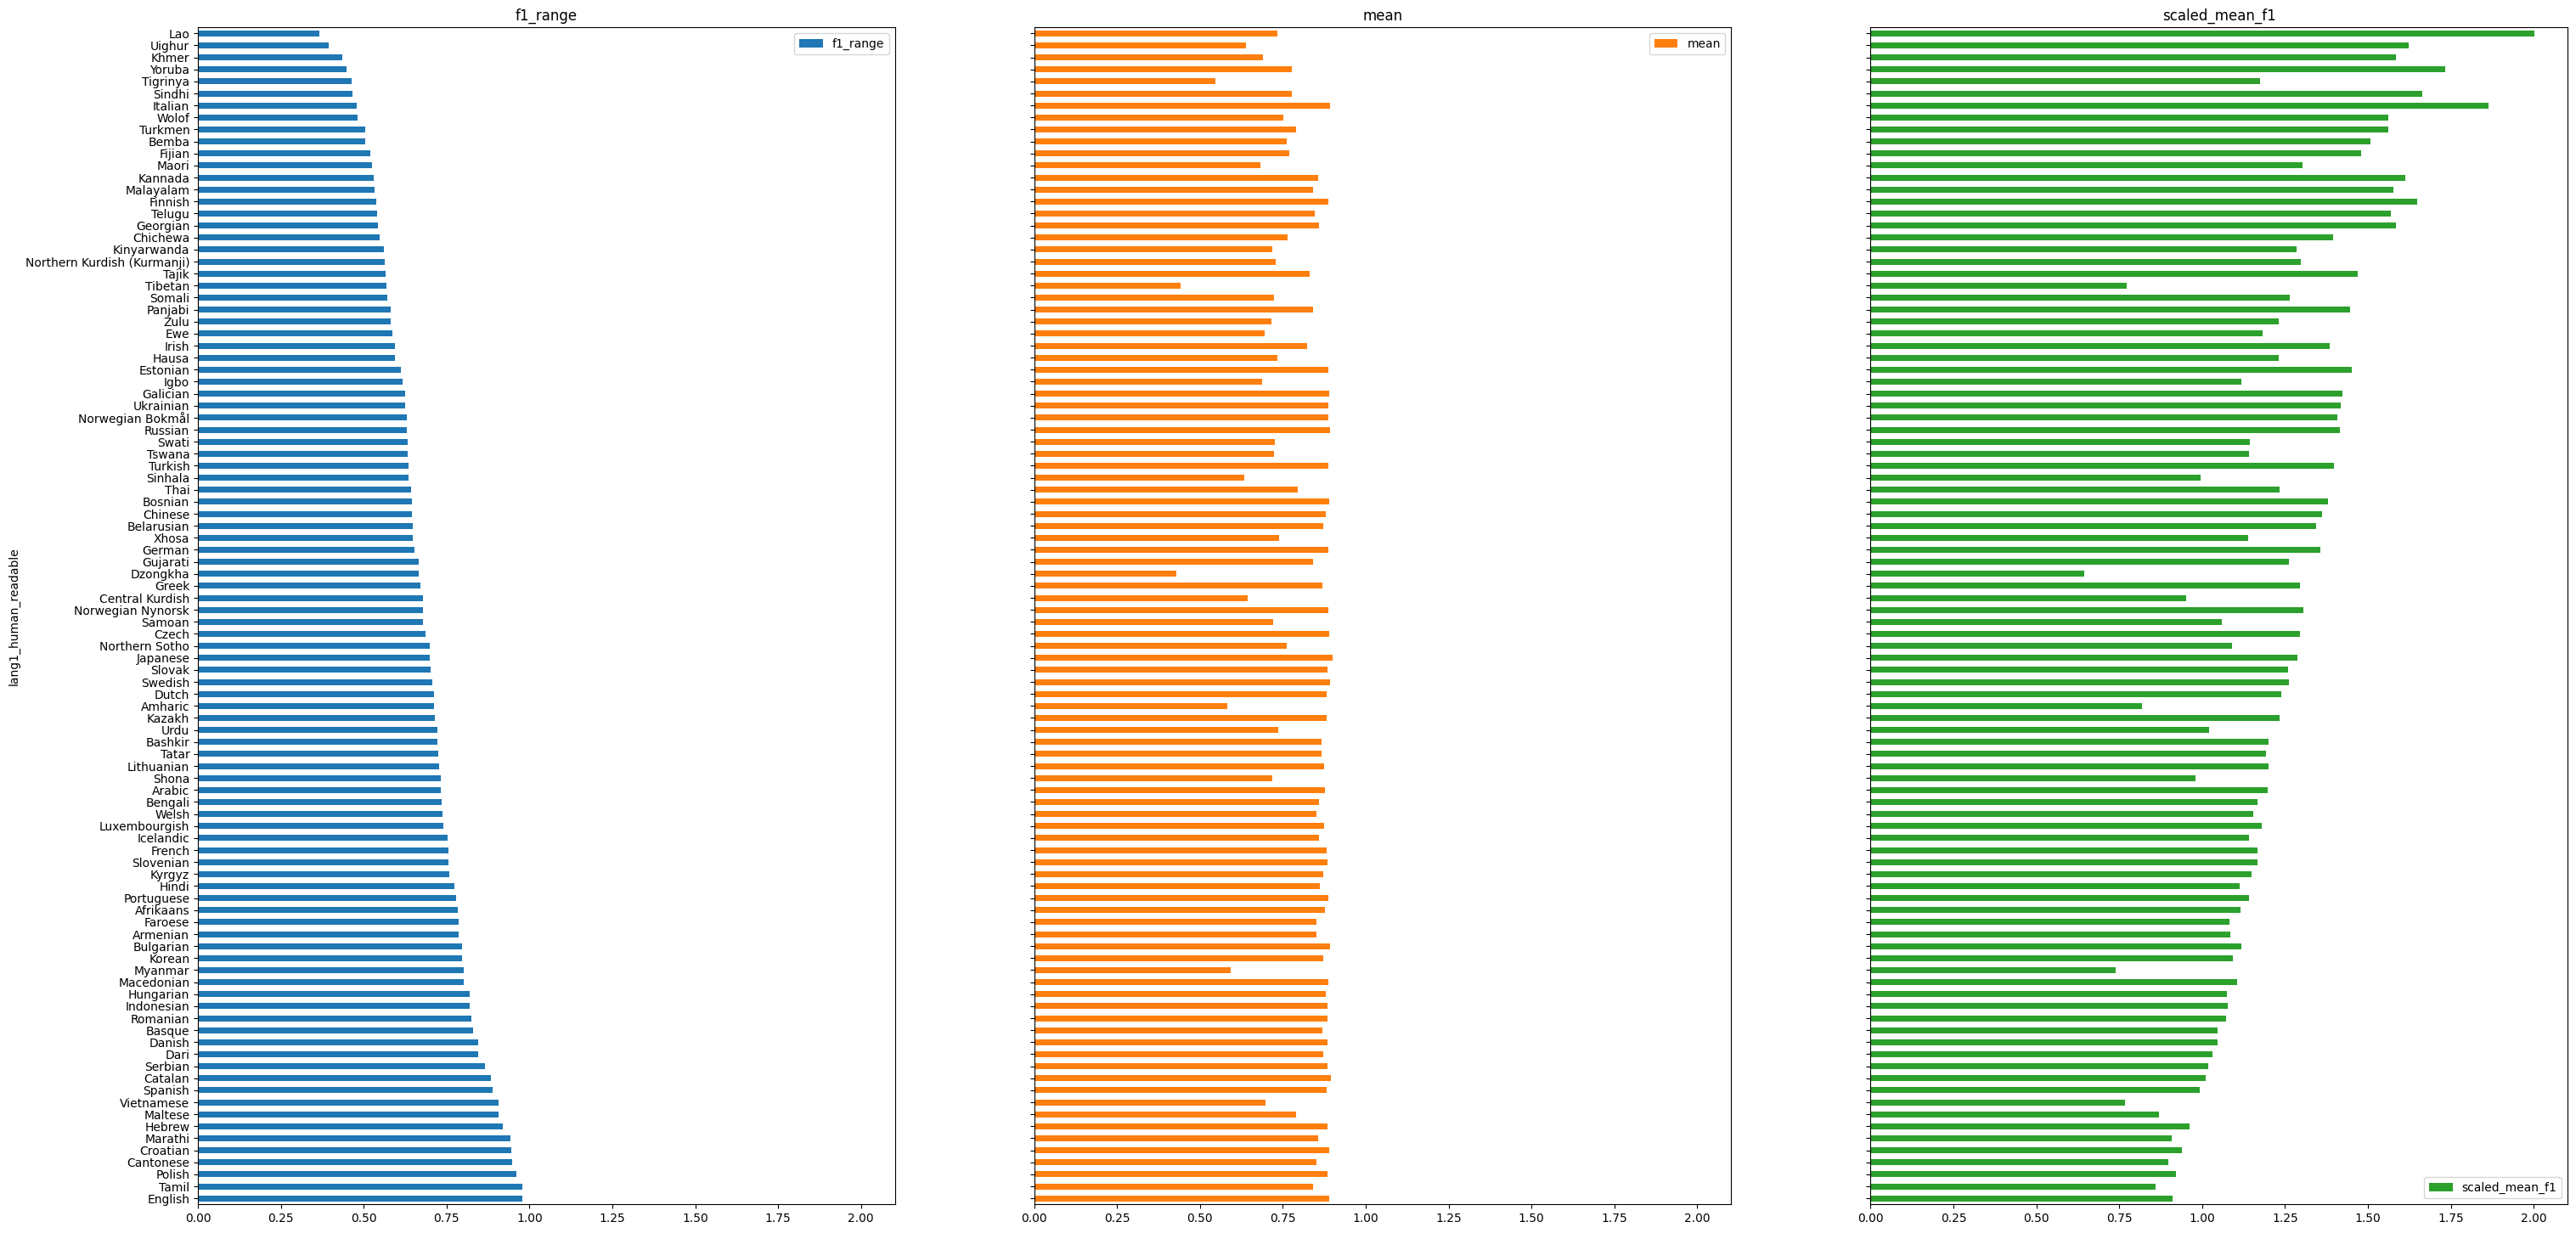

In [201]:
prf1.groupby('lang1_human_readable').f1_after.describe()\
.assign(
    f1_range=lambda row: row['max'] - row['min']
)\
.assign(
    scaled_mean_f1=lambda row: row['mean'] / row['f1_range']
)\
.sort_values('f1_range', ascending=False)[['f1_range','mean','scaled_mean_f1']]\
.plot(kind='barh', figsize=(36, 18), subplots=True, layout=(1,3), sharey=True)


array([[<Axes: title={'center': 'f1_range'}, ylabel='lang1'>,
        <Axes: title={'center': 'mean'}, ylabel='lang1'>,
        <Axes: title={'center': 'std'}, ylabel='lang1'>,
        <Axes: title={'center': 'scaled_mean_f1'}, ylabel='lang1'>]],
      dtype=object)

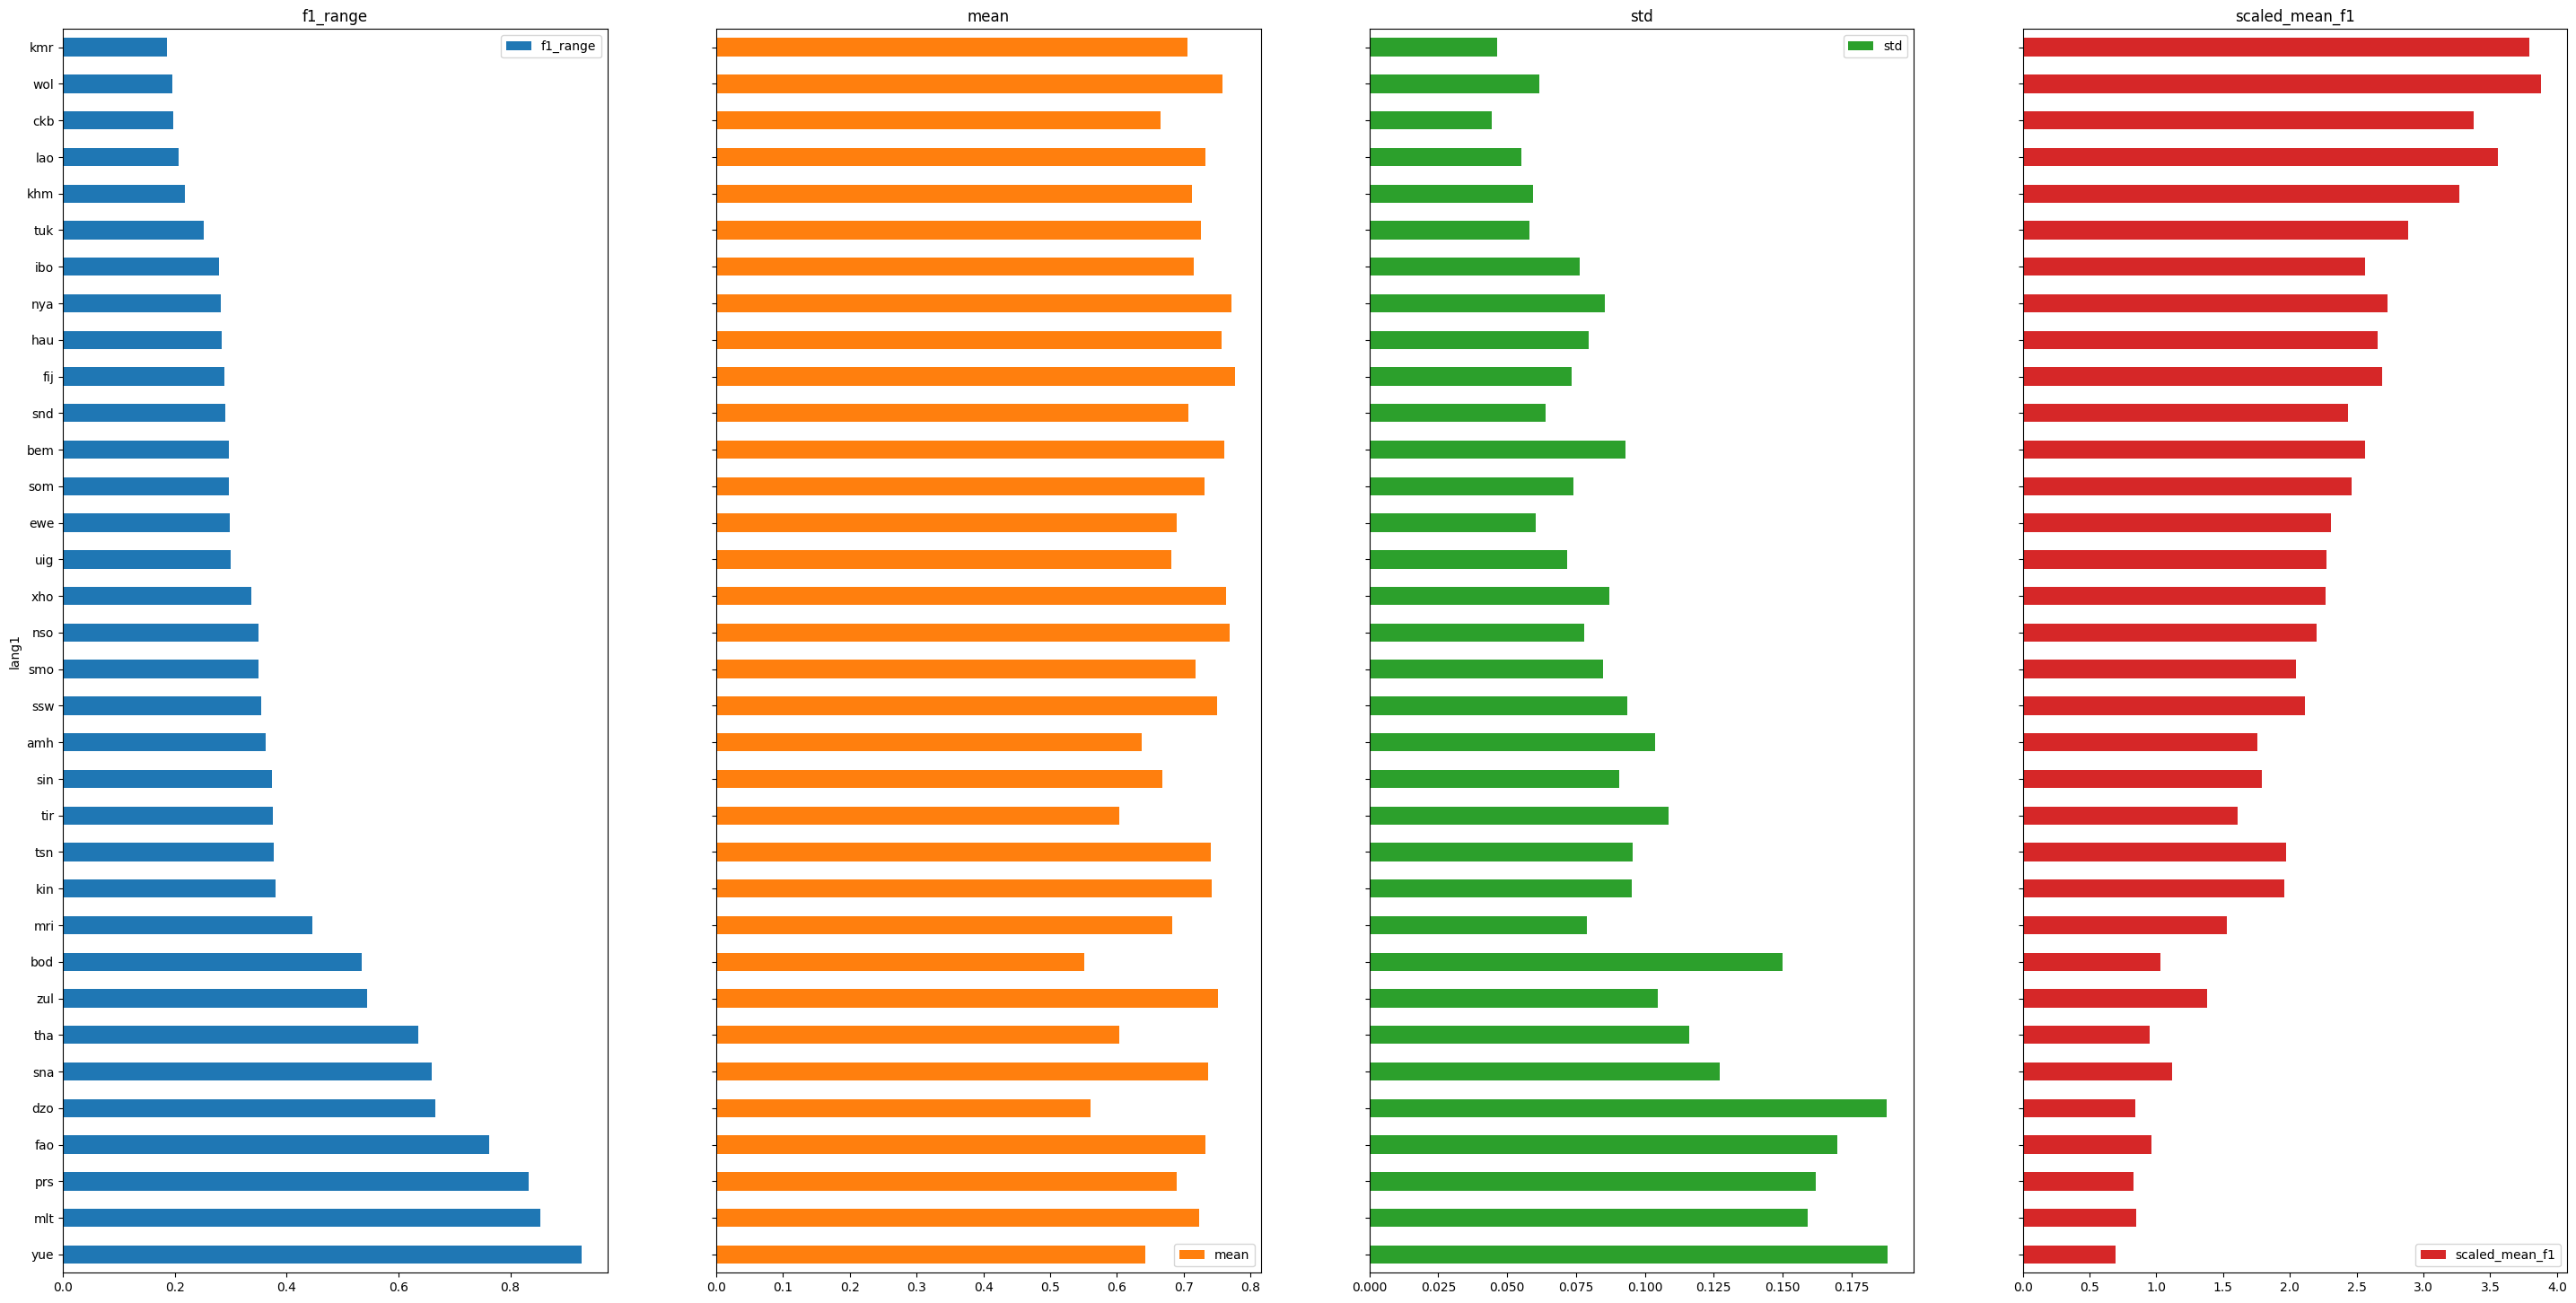

In [206]:
prf1[prf1.neither_in_mbert.astype(bool)].groupby('lang1').f1_after.describe()\
.assign(
    f1_range=lambda row: row['max'] - row['min']
)\
.assign(
    scaled_mean_f1=lambda row: row['mean'] / row['f1_range']
)\
.sort_values('f1_range', ascending=False)[['f1_range','mean', 'std','scaled_mean_f1']]\
.plot(kind='barh', figsize=(36, 18), subplots=True, layout=(1,4), sharey=True, sharex=False)


What are the best languages for each mBERT status?

In [86]:
def classify_by_mbert_status(row):
    if row.both_in_mbert == 1:
        return "both"
    elif row.at_least_one_in_mbert == 1:
        return 'at_least_one'
    else:
        return 'neither'
    
prf1['mbert_status'] = prf1.apply(classify_by_mbert_status, axis=1)
prf1['mbert_status'] = pd.Categorical(prf1['mbert_status'], 
                                      ordered=True, 
                                      categories=[
                                          'neither', 
                                          'at_least_one', 
                                          'both'
                                      ])

In [87]:
import functools as ft

In [88]:
def get_top_language_pairs(df, N=10):
    out = df[['lang1', 'lang2', 'f1_after']]\
        .sort_values('f1_after', ascending=False)\
        .head(N)\
        .apply(lambda row: (row.lang1, row.lang2, round(row.f1_after, 2)), axis=1)\
        .tolist()
    
    out = ["{} - {} ({})".format(lang_to_human_readable_language[l1], 
                                 lang_to_human_readable_language[l2], f1) for l1, l2, f1 in out]
    return out


In [89]:
def get_lowest_variance_langs(df, N=10):
    out = df.groupby('lang1').f1_after.describe()[['mean', 'std']]\
        .reset_index()\
        .apply(lambda row: (row.lang1, row['mean'], row['std'], row['mean']/row['std']), axis=1)
    
    out = sorted(out, key=lambda t: t[-1], reverse=True)[:N]
    
    out = ["{} ({}, {})".format(lang_to_human_readable_language[l1], round(m, 2), round(sd, 2)) for l1, m, sd, _ in out]
    return out


In [90]:
top_language_pairs_by_mbert_status = pd.DataFrame(
    prf1.groupby('mbert_status')
        .apply(ft.partial(get_top_language_pairs, N=50))
        .to_dict()
)

In [91]:
#top_language_pairs_by_mbert_status

In [95]:
top_language_pairs_by_mbert_status

neither                         at_least_one  \
0            Dari - Cantonese (0.98)            Cantonese - Chinese (1.0)   
1            Cantonese - Dari (0.98)           Chinese - Cantonese (0.99)   
2              Dari - Faroese (0.95)          Cantonese - Japanese (0.99)   
3     Northern Sotho - Tswana (0.95)                English - Dari (0.99)   
4              Faroese - Dari (0.95)           Cantonese - English (0.99)   
5     Tswana - Northern Sotho (0.94)                Dari - English (0.99)   
6         Faroese - Cantonese (0.93)          Cantonese - Galician (0.99)   
7               Xhosa - Swati (0.93)           Catalan - Cantonese (0.99)   
8               Swati - Xhosa (0.92)           English - Cantonese (0.99)   
9                 Thai - Dari (0.92)                Dari - Bosnian (0.99)   
10              Sindhi - Dari (0.91)           Cantonese - Russian (0.99)   
11        Cantonese - Faroese (0.91)            French - Cantonese (0.99)   
12           Thai - Cantonese (0.91)             Dari - Indonesian (0.99)   
13               Swati - Zulu (0.91)           Russian - Cantonese (0.99)   
14                 Dari - Thai (0.9)           Spanish - Cantonese (0.99)   
15                Zulu - Swati (0.9)                Russian - Dari (0.99)   
16                Xhosa - Zulu (0.9)           Cantonese - Spanish (0.99)   
17                Zulu - Xhosa (0.9)             Cantonese - Dutch (0.99)   
18           Cantonese - Thai (0.89)           Italian - Cantonese (0.99)   
19           Chichewa - Bemba (0.89)            Cantonese - French (0.99)   
20           Bemba - Chichewa (0.88)            German - Cantonese (0.99)   
21  Chichewa - Northern Sotho (0.88)          Cantonese - Romanian (0.99)   
22              Dari - Sindhi (0.88)                Italian - Dari (0.99)   
23             Dari - Maltese (0.88)            Cantonese - Danish (0.99)   
24              Bemba - Xhosa (0.88)         Cantonese - Ukrainian (0.99)   
25              Shona - Xhosa (0.87)  Cantonese - Norwegian Bokmål (0.99)   
26           Chichewa - Xhosa (0.87)             Dari - Portuguese (0.99)   
27              Xhosa - Bemba (0.87)                Dari - Spanish (0.99)   
28              Xhosa - Shona (0.87)        Cantonese - Indonesian (0.99)   
29     Bemba - Northern Sotho (0.87)        Cantonese - Portuguese (0.99)   
30             Tswana - Xhosa (0.87)                Dari - Catalan (0.99)   
31     Xhosa - Northern Sotho (0.87)          Galician - Cantonese (0.99)   
32          Tswana - Chichewa (0.87)               Dari - Romanian (0.99)   
33             Tswana - Bemba (0.87)             Portuguese - Dari (0.99)   
34           Chichewa - Hausa (0.87)           Cantonese - Italian (0.99)   
35  Northern Sotho - Chichewa (0.86)             Dutch - Cantonese (0.99)   
36             Fijian - Xhosa (0.86)          Cantonese - Croatian (0.99)   
37               Zulu - Bemba (0.86)                  Dari - Dutch (0.99)   
38              Bemba - Hausa (0.86)          Japanese - Cantonese (0.99)   
39             Bemba - Fijian (0.86)              Bulgarian - Dari (0.99)   
40    Northern Sotho - Fijian (0.86)               Galician - Dari (0.99)   
41           Xhosa - Chichewa (0.86)                 Polish - Dari (0.99)   
42     Northern Sotho - Shona (0.86)          Romanian - Cantonese (0.99)   
43         Sindhi - Cantonese (0.86)               Dari - Galician (0.99)   
44          Chichewa - Tswana (0.86)              Hungarian - Dari (0.99)   
45          Chichewa - Fijian (0.86)              Dari - Bulgarian (0.99)   
46              Shona - Swati (0.86)                Spanish - Dari (0.99)   
47    Fijian - Northern Sotho (0.86)            Cantonese - German (0.99)   
48              Swati - Shona (0.86)                Dari - Chinese (0.99)   
49     Swati - Northern Sotho (0.86)              Dari - Ukrainian (0.99)   

                                          both  
0              Danish - Norwegian Bokmål (1.0)  
1  

In [96]:
highest_mean_to_variance_ratio_langs = pd.DataFrame(
    prf1.groupby('mbert_status')
        .apply(ft.partial(get_lowest_variance_langs, N=20))
        .to_dict()
)

In [97]:
highest_mean_to_variance_ratio_langs

neither                 at_least_one  \
0   Northern Kurdish (Kurmanji) (0.71, 0.05)            Dari (0.97, 0.04)   
1               Central Kurdish (0.67, 0.04)         Faroese (0.91, 0.06)   
2                           Lao (0.73, 0.06)       Cantonese (0.96, 0.07)   
3                       Turkmen (0.73, 0.06)            Thai (0.89, 0.06)   
4                         Wolof (0.76, 0.06)          Yoruba (0.75, 0.06)   
5                         Khmer (0.71, 0.06)             Lao (0.73, 0.06)   
6                           Ewe (0.69, 0.06)           Bemba (0.76, 0.07)   
7                        Sindhi (0.71, 0.06)        Chichewa (0.76, 0.07)   
8                        Fijian (0.78, 0.07)         Turkmen (0.82, 0.08)   
9                        Somali (0.73, 0.07)              Ewe (0.7, 0.07)   
10               Northern Sotho (0.77, 0.08)  Northern Sotho (0.76, 0.08)   
11                       Uighur (0.68, 0.07)             Zulu (0.7, 0.07)   
12                        Hausa (0.76, 0.08)           Swati (0.71, 0.08)   
13                         Igbo (0.72, 0.08)          Somali (0.72, 0.08)   
14                     Chichewa (0.77, 0.09)           Wolof (0.75, 0.08)   
15                        Xhosa (0.76, 0.09)          Fijian (0.77, 0.08)   
16                        Maori (0.68, 0.08)          Sindhi (0.81, 0.09)   
17                       Samoan (0.72, 0.08)           Hausa (0.72, 0.08)   
18                        Bemba (0.76, 0.09)          Tswana (0.71, 0.08)   
19                        Swati (0.75, 0.09)          Maltese (0.82, 0.1)   

                             both  
0           Japanese (0.97, 0.03)  
1            English (0.98, 0.04)  
2             German (0.97, 0.04)  
3            Serbian (0.97, 0.04)  
4            Russian (0.97, 0.04)  
5           Romanian (0.97, 0.04)  
6            Kannada (0.94, 0.04)  
7          Bulgarian (0.97, 0.04)  
8   Norwegian Bokmål (0.97, 0.04)  
9          Ukrainian (0.97, 0.04)  
10            Hebrew (0.96, 0.04)  
11           Bosnian (0.97, 0.04)  
12        Macedonian (0.97, 0.04)  
13             Hindi (0.96, 0.04)  
14           Swedish (0.97, 0.05)  
15          Estonian (0.96, 0.05)  
16           Catalan (0.97, 0.05)  
17          Croatian (0.97, 0.05)  
18           Turkish (0.96, 0.05)  
19            French (0.97, 0.05)

array([[<Axes: title={'center': 'neither'}, ylabel='lang1_human_readable'>,
        <Axes: title={'center': 'at_least_one'}, ylabel='lang1_human_readable'>,
        <Axes: title={'center': 'both'}, ylabel='lang1_human_readable'>,
        <Axes: title={'center': 'total'}, ylabel='lang1_human_readable'>]],
      dtype=object)

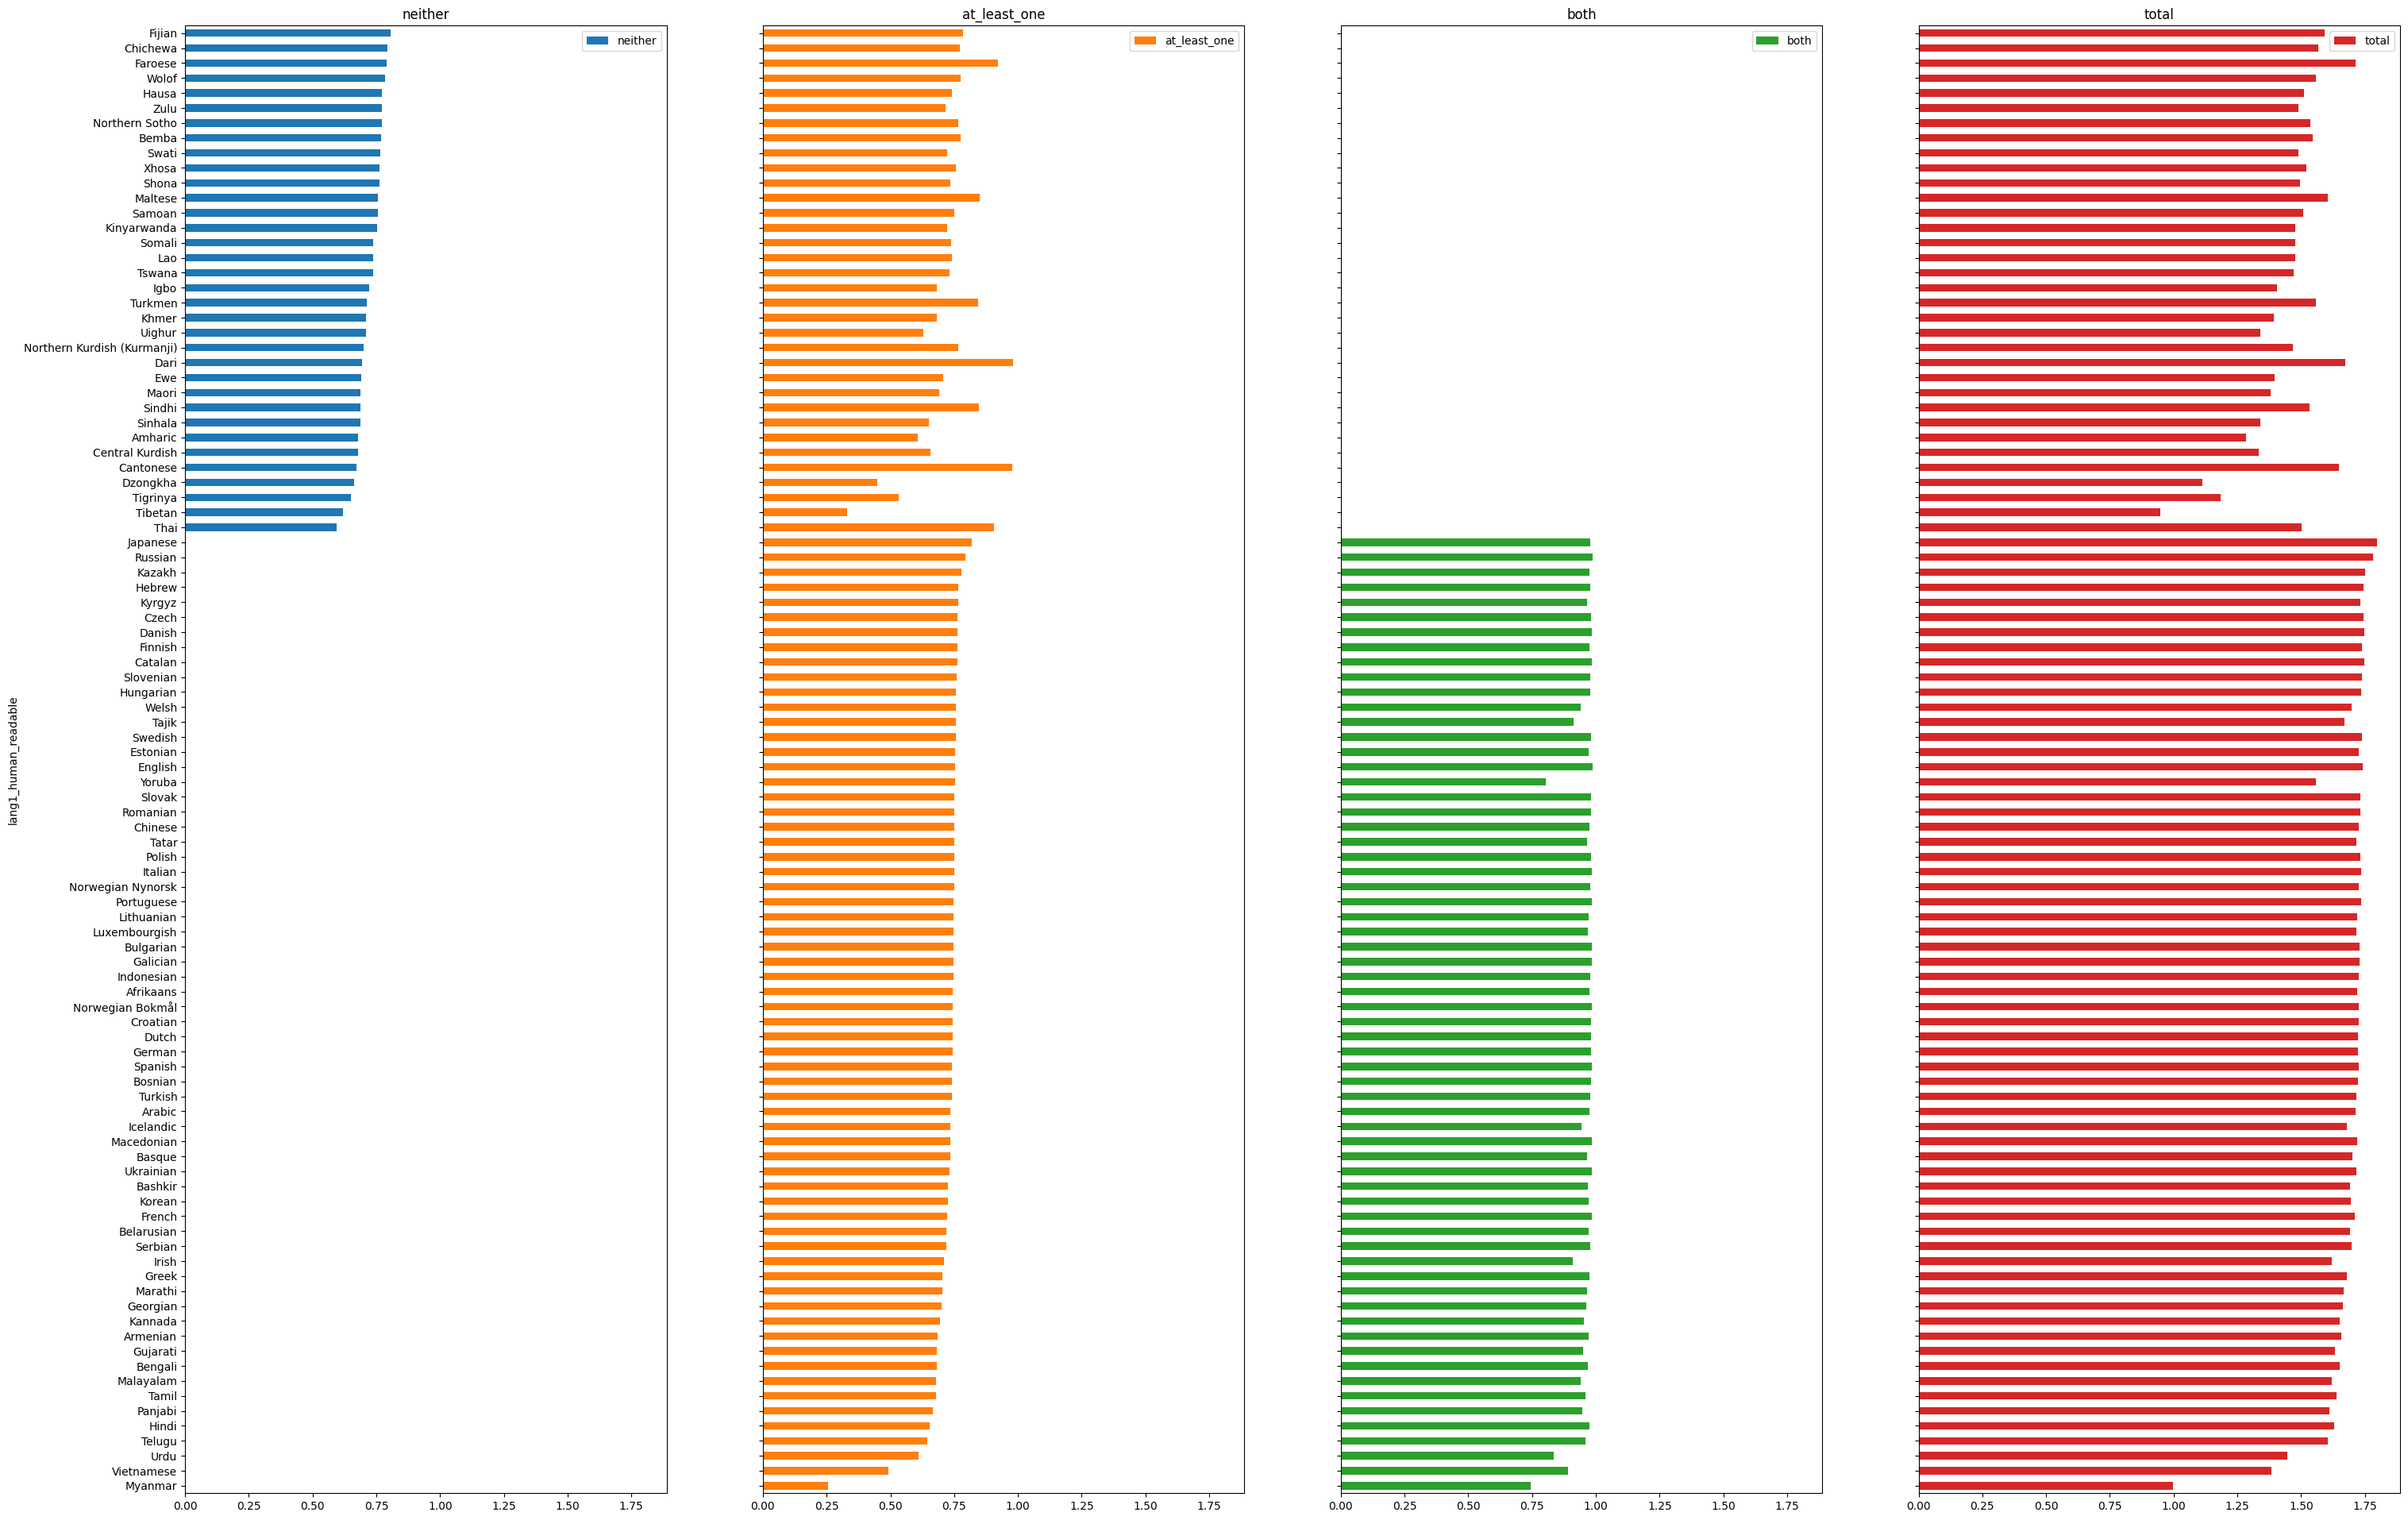

In [98]:
___ = prf1.groupby(['lang1_human_readable', 'mbert_status']).f1_after.median().unstack(level=-1).fillna(0)
___['total'] = ___.sum(axis=1)
___.sort_values(['neither', 'at_least_one', 'both'], ascending=True)\
    .plot(
        kind='barh', 
        figsize=(36, 24), 
        stacked=False, 
        subplots=True, 
        layout=(1,4),
        sharey=True,
        sharex=True,
    )

## Heatmap table

In [212]:
def get_heatmap_df(prf1, f1_col="f1_after", 
                   figsize=(48, 48), 
                   should_annotate=False, 
                   sort_col="cluster_index"):
    __df = prf1.set_index(['lang1', 'lang2']).sort_values(sort_col)[f1_col].unstack(level=-1)
    __df = __df.loc[ordered_languages, ordered_languages]
    
    __df.index = [f"{lang} ({lang2cluster_id[lang]})" for lang in __df.index]
    __df.columns = [f"{lang} ({lang2cluster_id[lang]})" for lang in __df.columns]
    return __df

In [214]:
print(get_heatmap_df(prf1).fillna(0).to_latex())

/tmp/ipykernel_2470519/4214654736.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(get_heatmap_df(prf1).fillna(0).to_latex())


\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
{} &   afr (0) &   arb (0) &   bak (0) &   bel (0) &   ben (0) &   bos (0) &   bul (0) &   cat (0) &   ces (0) &   cym (0) &   dan (0) &   deu (0) &   ell (0) &   eng (0) &   est (0) &   eus (0) &   fao (0) &   fin (0) &   fra (0) &   gle (0) &   glg (0) &   guj (0) &   heb (0) &   hin (0) &   hrv (0) &   hun (0) &   hye (0) &   ind (0) &   isl (0) &   ita (0) &   jpn (0) &   kan (0) &   kat (0) &   kaz (0) &   kir (0) &   kor (0) &   lit (0) &   ltz (0) &   mal (0) &   mar (0) &   mkd (0) &   mlt (0) &   nld (0) &   nno (0) &   nob (0) &   pan (0) &   pol (0) &   por (0) &   prs (0) &   ron (0) &   rus (0) &   slk (0) &   slv (0) &   spa (0) &   srp (0) &   swe (0) &   tam (0) &   tat (0) &   tel (0) &   tgk (0) &   tha (0) &   tur (0) &   ukr (0) &   yue (0) &   zho (0) &   amh (1) &   bem (1) &   bod (1) &   ckb (1) &   dzo (1) &   ewe (1) &   fij (1) &   hau

## Model

In [102]:
mbert_inclusion_vs_delta_f1 = smf.ols('f1_after ~ C(lang1_in_mbert):C(lang2_in_mbert) + C(lang1) + C(lang2)', data=prf1).fit()

## How close/far are Farsi and Dari?